### Realizamos la carga de los datos

In [ ]:
#-- Descomprimimos el dataset
!rm -r mnist
!unzip mnist.zip

In [4]:
#--- Buscamos las direcciones de cada archivo de imagen
from glob import glob

train_files = glob('./mnist/train/*/*.png')
valid_files = glob('./mnist/valid/*/*.png')
test_files = glob('./mnist/test/*/*.png')

In [6]:
#--- Ordenamos los datos de forma aleatoria para evitar sesgos
import numpy as np

np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

len(train_files), len(valid_files), len(test_files)

(6000, 2000, 992)

In [7]:
#--- Cargamos los datos de entrenamiento en listas
from PIL import Image

N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))

In [8]:
#--- Cargamos los datos de validación en listas
N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)) )

In [9]:
#--- Cargamos los datos de testeo en listas
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )

In [10]:
#--- Convetimos las listas con los datos a tensores de torch
import torch
from torch.autograd import Variable


X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

torch.Size([6000, 28, 28])

### Definimos la matriz de confusión

In [26]:
from sklearn.metrics import confusion_matrix

def CM(Y_true, Y_pred, classes):
  fig = plt.figure(figsize=(10, 10))
  cm = confusion_matrix(Y_true, Y_pred)
  lclasses = np.arange(0,classes)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cmap=plt.cm.Blues
  ax = fig.add_subplot(1,1,1)
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.86)
  ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=lclasses, yticklabels=lclasses)
  ax.set_xlabel("Predicted",size=20)
  ax.set_ylabel("True",size=20)
  ax.set_ylim(classes-0.5, -0.5)

  plt.setp(ax.get_xticklabels(), size=12)
  plt.setp(ax.get_yticklabels(), size=12)

  fmt = '.2f'
  thresh = cm.max()/2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=15 , color="white" if cm[i, j] > thresh else "black")

  plt.show()
  return fig

### Metaparametros a estudiar
- **n_epoch** = Número de épocas
- **lr** = Tasa de aprendizaje 
- **weight_decay** = peso de decaímiento
- **batch_size** = Tamaño del subconjunto


#### Según un modelo que suponemos ya creado, definimos el ciclo de aprendizaje

In [27]:
from sklearn.metrics import f1_score

def train_valid(model, n_epoch, optimizer, criterion):
  loss_train = []
  f1_train = []
  acc_train = []

  loss_valid = []
  f1_valid = []
  acc_valid = []

  for epoch in range(n_epoch):
    model.train()

    Xtr = X_train.view(X_train.size(0), -1)
    Y_pred = model(Xtr)

    loss = criterion(Y_pred,Y_train)
    loss_train.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
    
    acc = sum(Y_train == Y_pred)/len(Y_pred)
    acc_train.append(acc)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    Xvl = X_valid.view(X_valid.size(0), -1)
    Y_pred = model(Xvl)  
    loss = criterion(Y_pred,Y_valid)
    loss_valid.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

    acc = sum(Y_valid == Y_pred)/len(Y_pred)
    acc_valid.append(acc)

  print( 'Valid Evaluation loss: {}. f1:{} acc: {} '.format(loss_valid[-1], f1_valid[-1], acc_valid[-1]) )
  matrix = CM(Y_valid, Y_pred, 10)
  return f1_valid[-1], matrix

#### Definimos la lista de los metaparámetros, creamos el primer modelo con 100 neuronas ocultas y 5 capas, y corremos su aprendizaje evaluándolo con la matriz de confusión.

  0%|          | 0/81 [00:00<?, ?it/s]

ne: 50, wd:0.001, lr: 0.001, bs:256 
Valid Evaluation loss: 0.3802633583545685. f1:0.8913074762587104 acc: 0.8914999961853027 


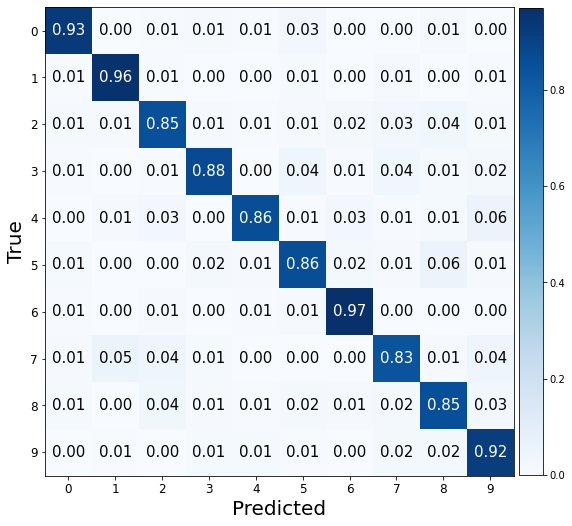

###################

ne: 50, wd:0.01, lr: 0.001, bs:256 
Valid Evaluation loss: 0.4033810496330261. f1:0.8833154333038878 acc: 0.8834999799728394 


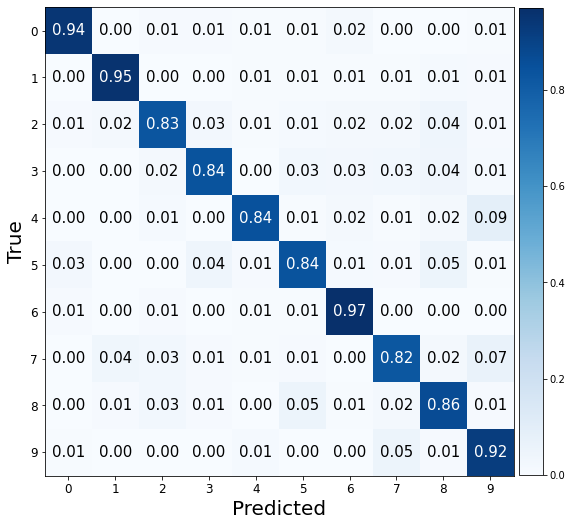

###################

ne: 50, wd:0.1, lr: 0.001, bs:256 
Valid Evaluation loss: 0.35622358322143555. f1:0.9037284377773493 acc: 0.9035000205039978 


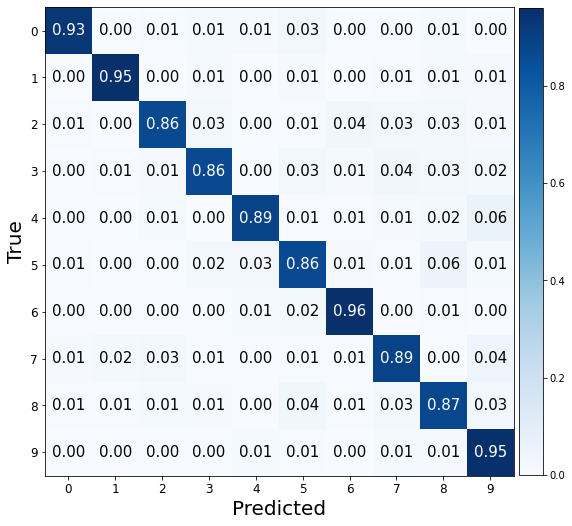

###################

ne: 50, wd:0.001, lr: 0.01, bs:256 
Valid Evaluation loss: 1.2642767429351807. f1:0.5712061691990051 acc: 0.5954999923706055 


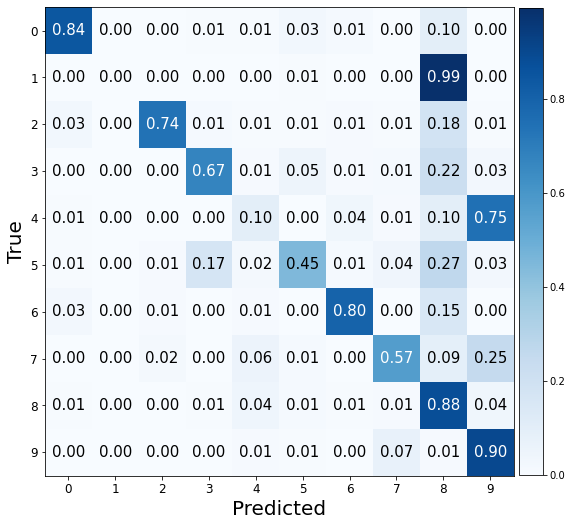

###################

ne: 50, wd:0.01, lr: 0.01, bs:256 
Valid Evaluation loss: 1.2931334972381592. f1:0.5502817697052491 acc: 0.5879999995231628 


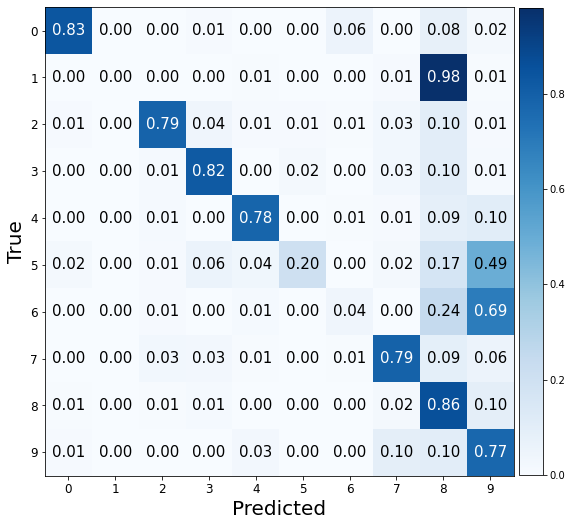

###################

ne: 50, wd:0.1, lr: 0.01, bs:256 
Valid Evaluation loss: 1.2105869054794312. f1:0.5716258216655068 acc: 0.6240000128746033 


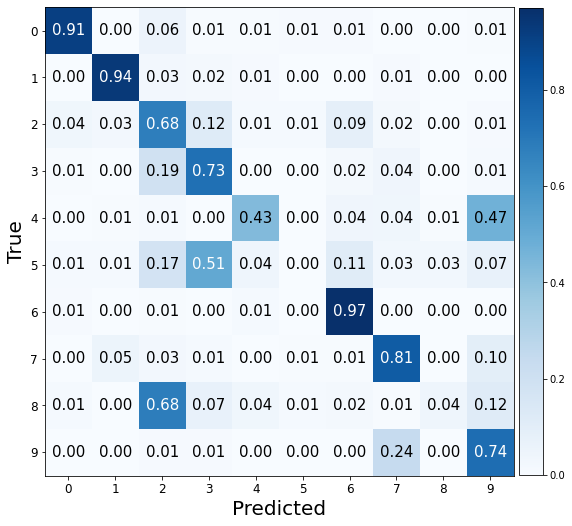

###################

ne: 50, wd:0.001, lr: 0.1, bs:256 
Valid Evaluation loss: 2.3026978969573975. f1:0.01818181818181818 acc: 0.10000000149011612 


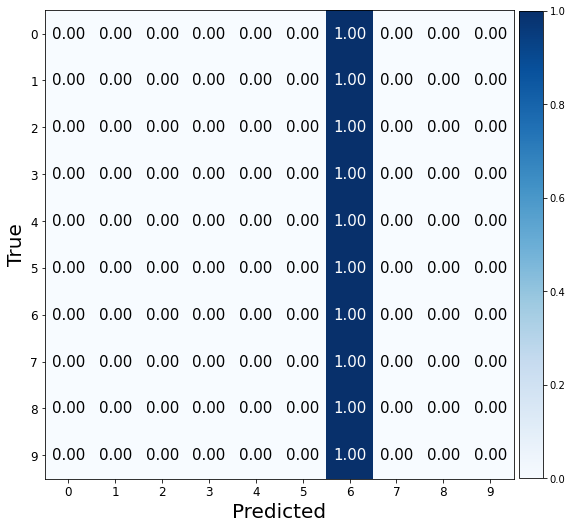

###################

ne: 50, wd:0.01, lr: 0.1, bs:256 
Valid Evaluation loss: 2.3026371002197266. f1:0.01818181818181818 acc: 0.10000000149011612 


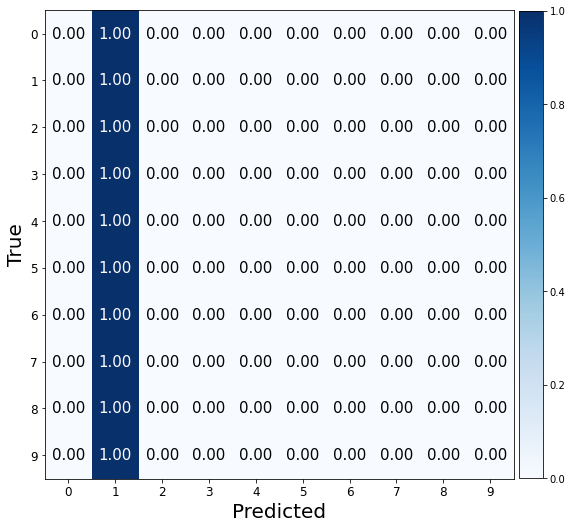

###################

ne: 50, wd:0.1, lr: 0.1, bs:256 
Valid Evaluation loss: 2.303812026977539. f1:0.12223390726056627 acc: 0.1720000058412552 


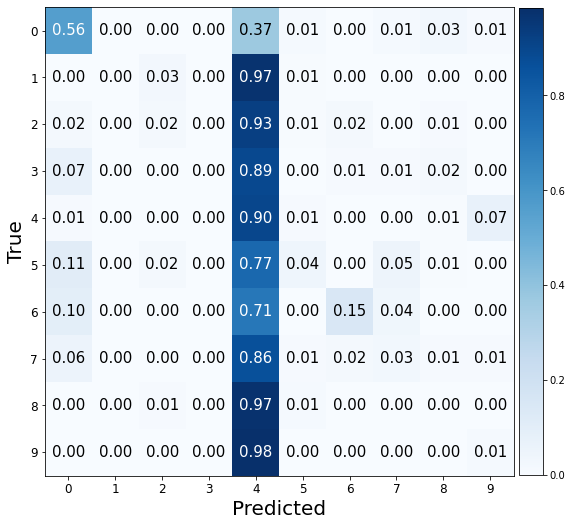

###################

ne: 50, wd:0.001, lr: 0.001, bs:512 
Valid Evaluation loss: 0.39646637439727783. f1:0.8892242613732986 acc: 0.8895000219345093 


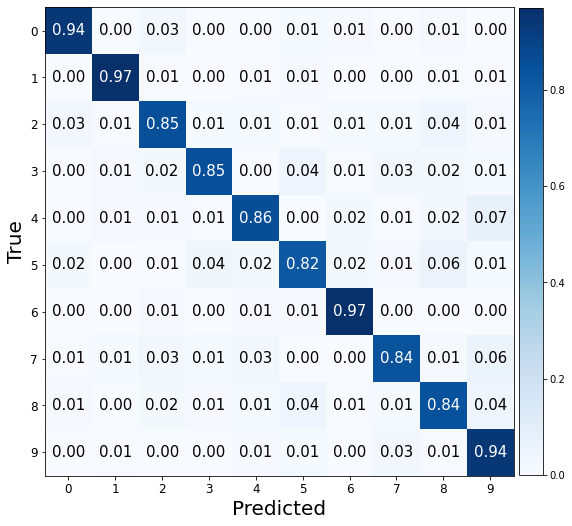

###################

ne: 50, wd:0.01, lr: 0.001, bs:512 
Valid Evaluation loss: 0.323531836271286. f1:0.9128828308037885 acc: 0.9129999876022339 


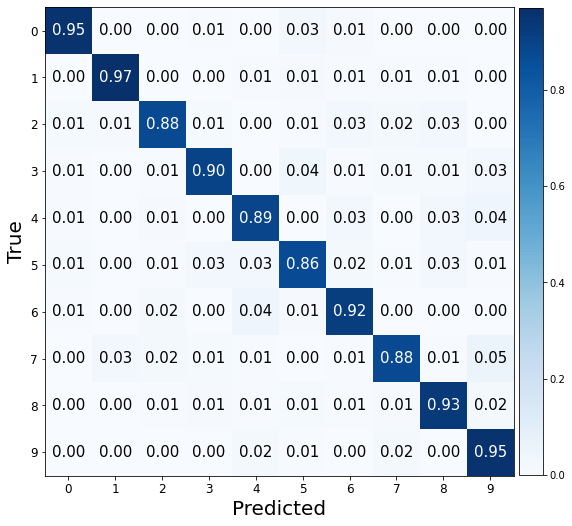

###################

ne: 50, wd:0.1, lr: 0.001, bs:512 
Valid Evaluation loss: 0.387929767370224. f1:0.8804722005299004 acc: 0.8805000185966492 


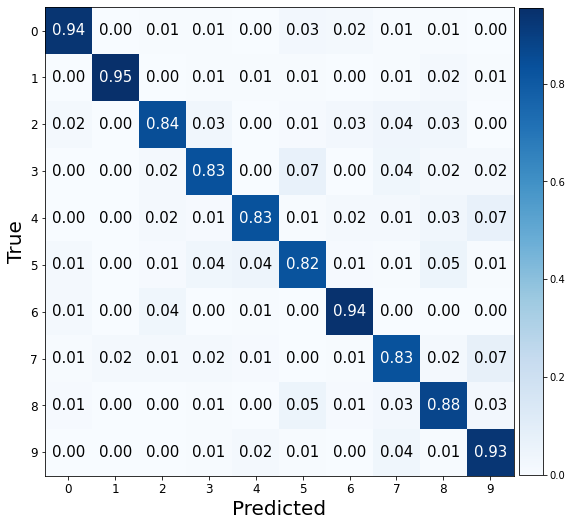

###################

ne: 50, wd:0.001, lr: 0.01, bs:512 
Valid Evaluation loss: 0.7607343792915344. f1:0.7910258484565088 acc: 0.7910000085830688 


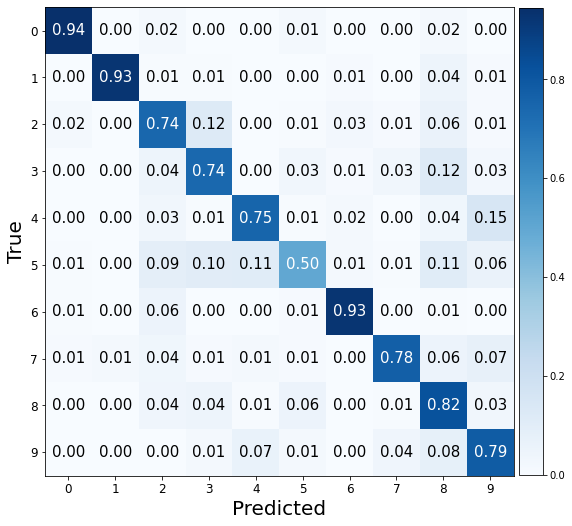

###################

ne: 50, wd:0.01, lr: 0.01, bs:512 
Valid Evaluation loss: 1.2568951845169067. f1:0.5821846965631797 acc: 0.6044999957084656 


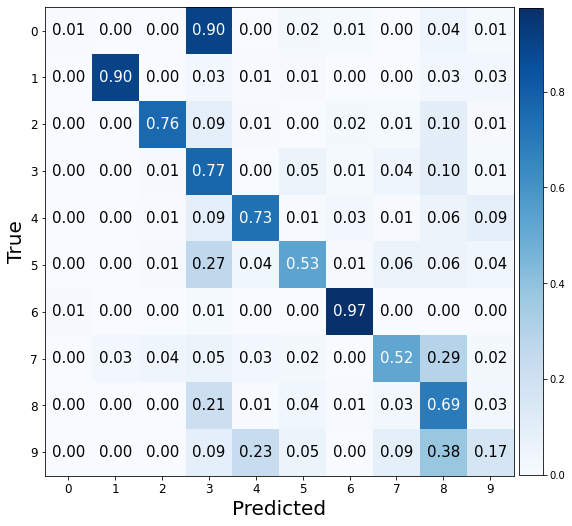

###################

ne: 50, wd:0.1, lr: 0.01, bs:512 
Valid Evaluation loss: 0.62444669008255. f1:0.8186363347737675 acc: 0.8169999718666077 


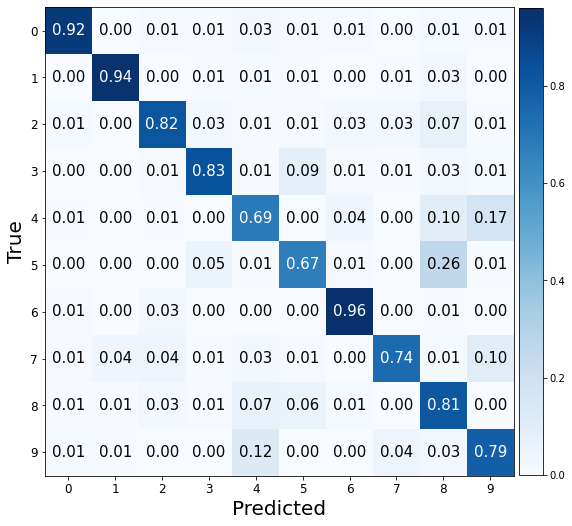

###################

ne: 50, wd:0.001, lr: 0.1, bs:512 
Valid Evaluation loss: 4.209019660949707. f1:0.01809913597089586 acc: 0.09950000047683716 


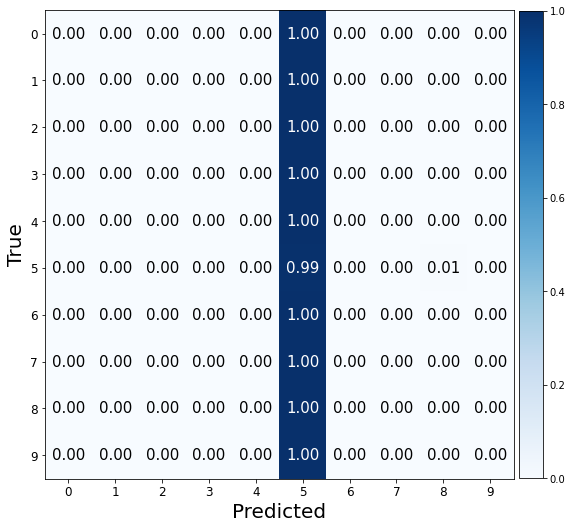

###################

ne: 50, wd:0.01, lr: 0.1, bs:512 
Valid Evaluation loss: 2.3026905059814453. f1:0.01818181818181818 acc: 0.10000000149011612 


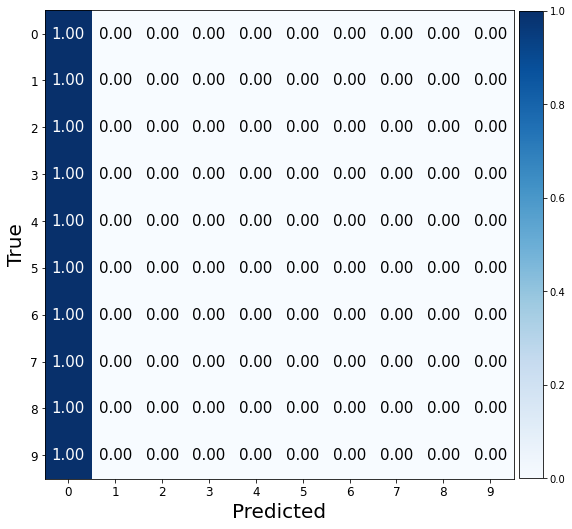

###################

ne: 50, wd:0.1, lr: 0.1, bs:512 
Valid Evaluation loss: 2.4500722885131836. f1:0.08052850759331832 acc: 0.13899999856948853 


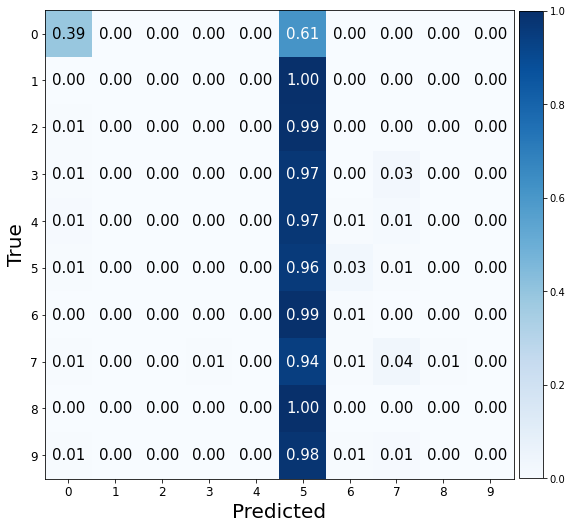

###################

ne: 50, wd:0.001, lr: 0.001, bs:1024 
Valid Evaluation loss: 0.34362509846687317. f1:0.91058112484795 acc: 0.9104999899864197 


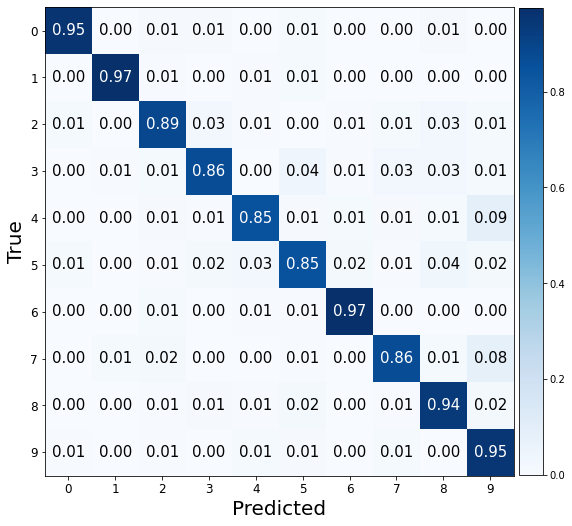

###################

ne: 50, wd:0.01, lr: 0.001, bs:1024 
Valid Evaluation loss: 0.4061184525489807. f1:0.9013805462865665 acc: 0.9014999866485596 


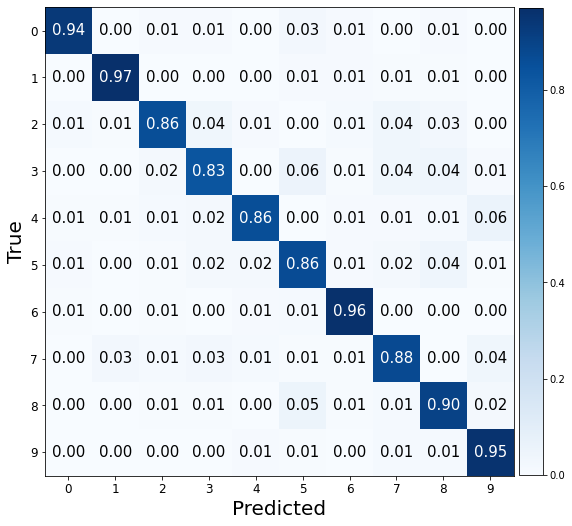

###################

ne: 50, wd:0.1, lr: 0.001, bs:1024 
Valid Evaluation loss: 0.39214837551116943. f1:0.8741676571566919 acc: 0.8734999895095825 


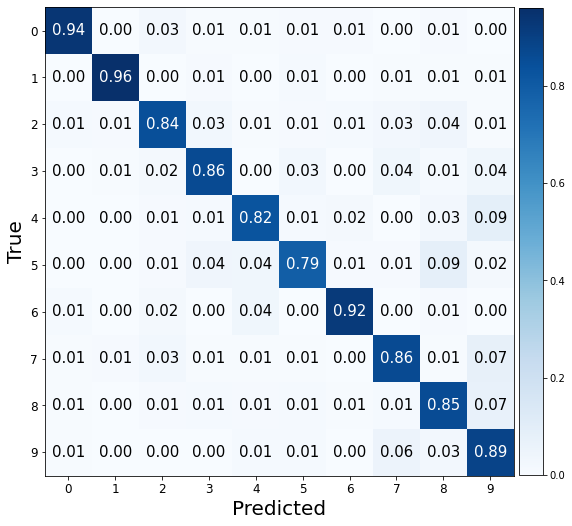

###################

ne: 50, wd:0.001, lr: 0.01, bs:1024 
Valid Evaluation loss: 0.7911826968193054. f1:0.7490461888104977 acc: 0.7584999799728394 


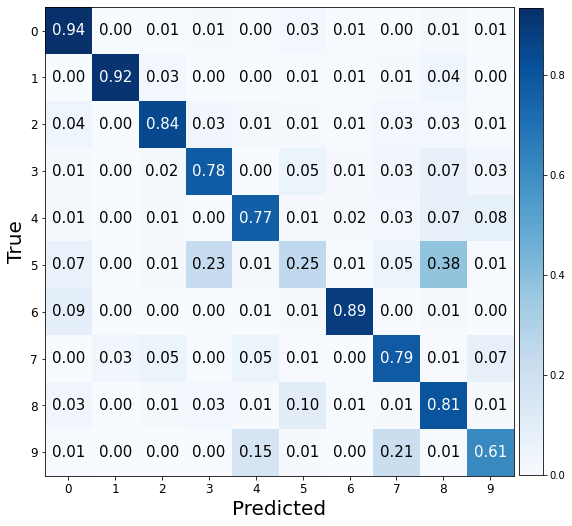

###################

ne: 50, wd:0.01, lr: 0.01, bs:1024 
Valid Evaluation loss: 0.926276683807373. f1:0.693647920260272 acc: 0.7120000123977661 


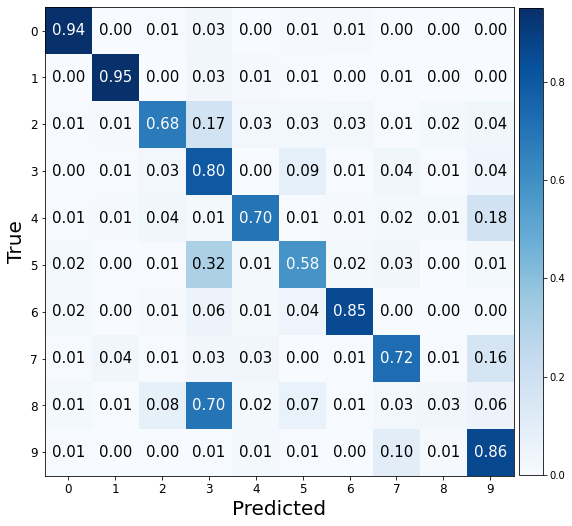

###################

ne: 50, wd:0.1, lr: 0.01, bs:1024 
Valid Evaluation loss: 1.3513939380645752. f1:0.48042259079570204 acc: 0.5105000138282776 


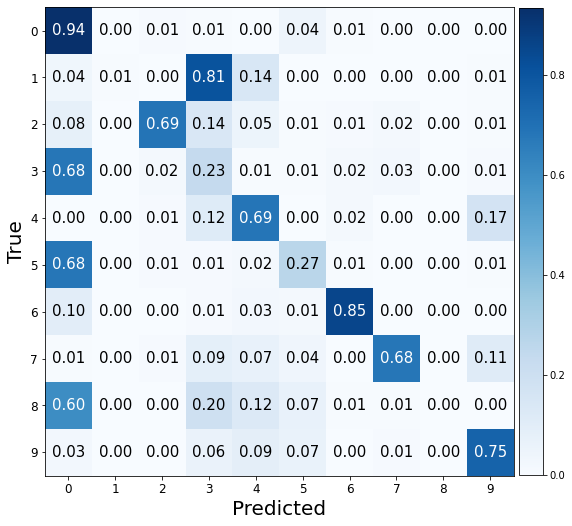

###################

ne: 50, wd:0.001, lr: 0.1, bs:1024 
Valid Evaluation loss: 2.302751302719116. f1:0.01818181818181818 acc: 0.10000000149011612 


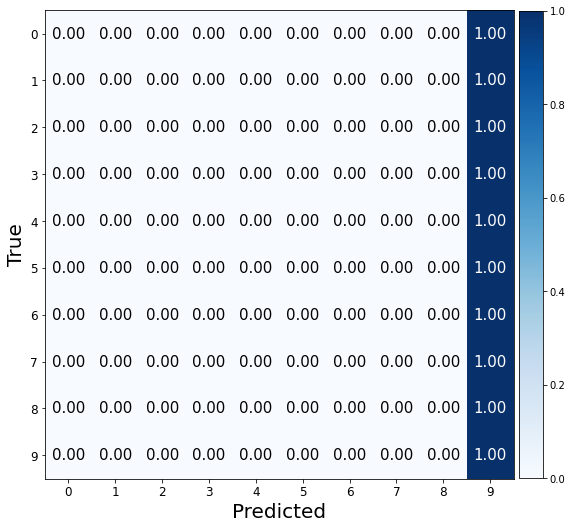

###################

ne: 50, wd:0.01, lr: 0.1, bs:1024 
Valid Evaluation loss: 2.3054769039154053. f1:0.01818181818181818 acc: 0.10000000149011612 


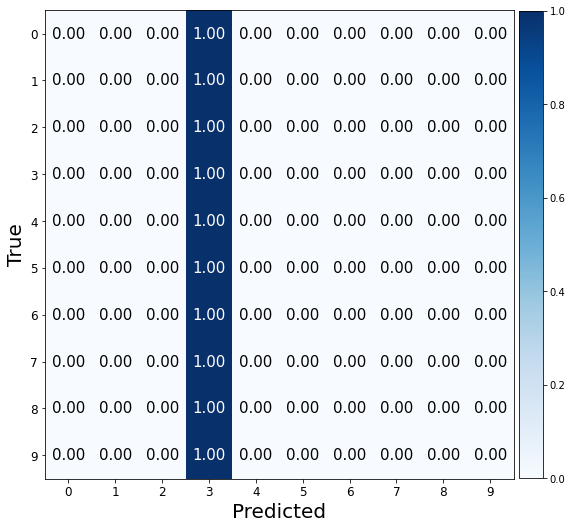

###################

ne: 50, wd:0.1, lr: 0.1, bs:1024 
Valid Evaluation loss: 2.7286975383758545. f1:0.1859157319669314 acc: 0.27799999713897705 


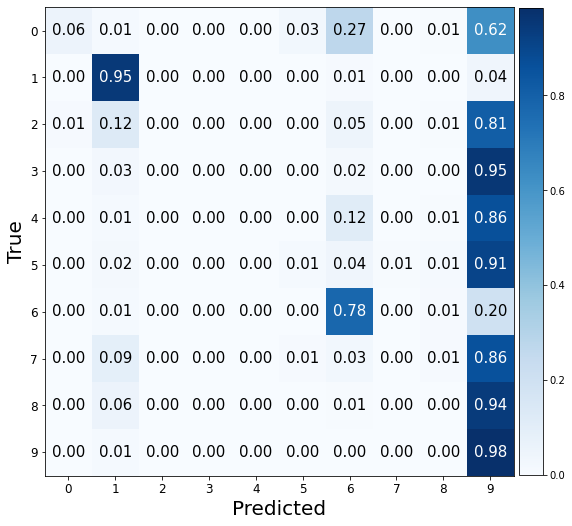

###################

ne: 100, wd:0.001, lr: 0.001, bs:256 
Valid Evaluation loss: 0.36565566062927246. f1:0.9015355215914486 acc: 0.9014999866485596 


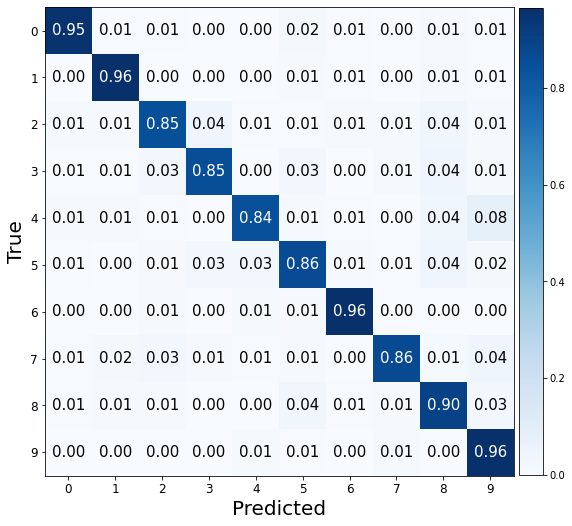

###################

ne: 100, wd:0.01, lr: 0.001, bs:256 
Valid Evaluation loss: 0.35223525762557983. f1:0.9080404073000903 acc: 0.9079999923706055 


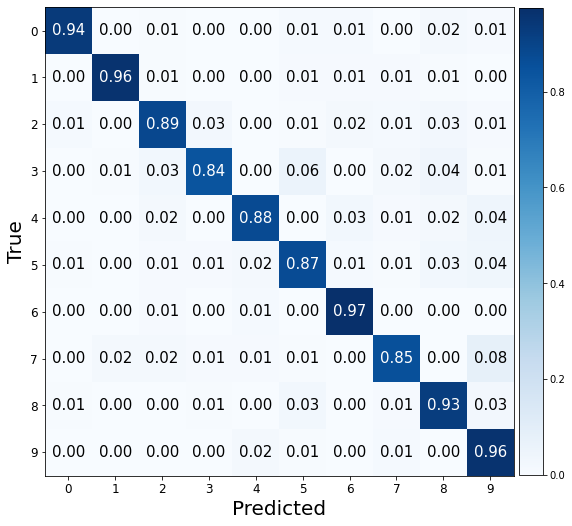

###################

ne: 100, wd:0.1, lr: 0.001, bs:256 
Valid Evaluation loss: 0.31174927949905396. f1:0.9049924041113806 acc: 0.9049999713897705 


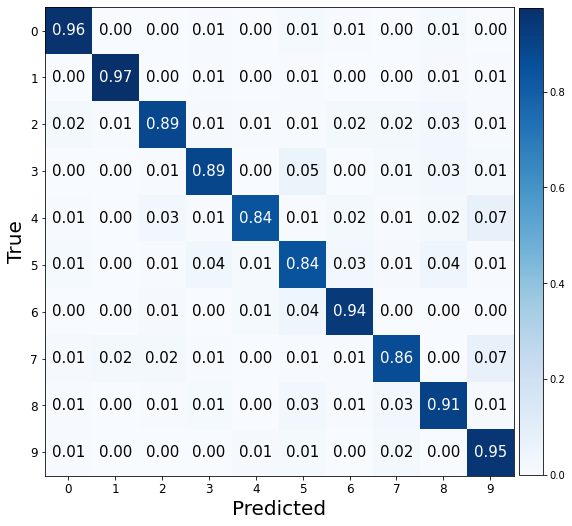

###################

ne: 100, wd:0.001, lr: 0.01, bs:256 
Valid Evaluation loss: 0.734453022480011. f1:0.848217623276185 acc: 0.8489999771118164 


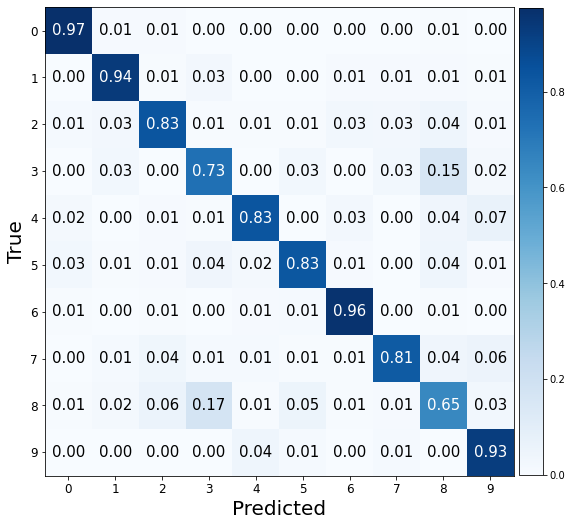

###################

ne: 100, wd:0.01, lr: 0.01, bs:256 
Valid Evaluation loss: 0.7381762266159058. f1:0.7475079367935961 acc: 0.765500009059906 


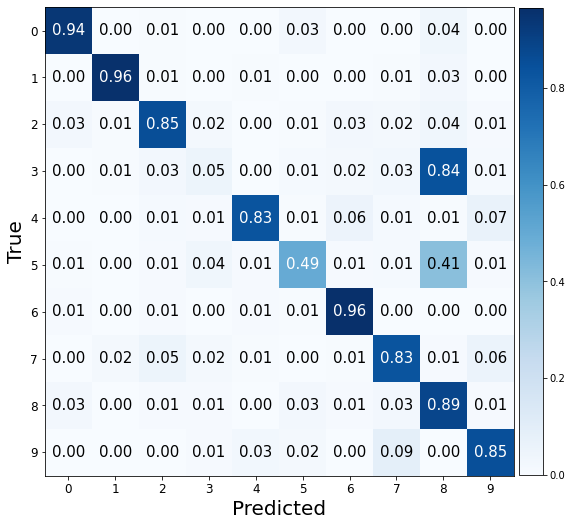

###################

ne: 100, wd:0.1, lr: 0.01, bs:256 
Valid Evaluation loss: 0.4965171813964844. f1:0.8486559404985623 acc: 0.8500000238418579 


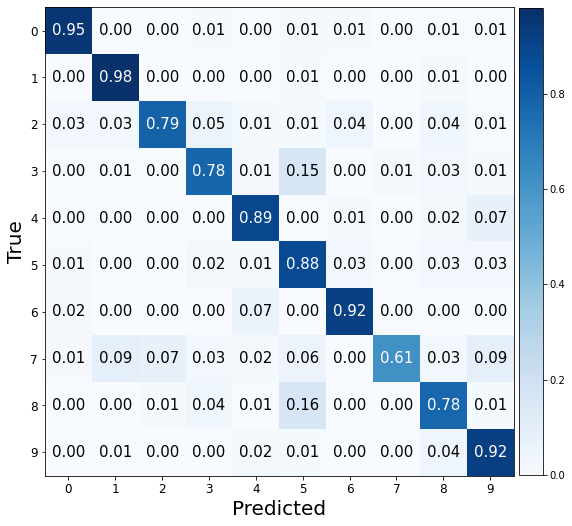

###################

ne: 100, wd:0.001, lr: 0.1, bs:256 
Valid Evaluation loss: 4.716540813446045. f1:0.07209934697969525 acc: 0.13650000095367432 


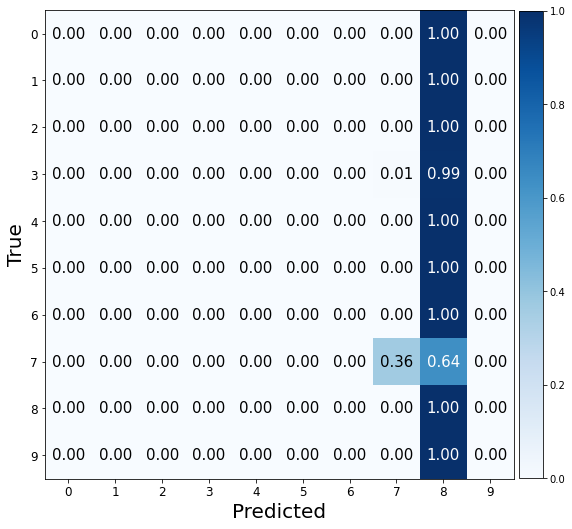

###################

ne: 100, wd:0.01, lr: 0.1, bs:256 
Valid Evaluation loss: 2.303539514541626. f1:0.018198362147406735 acc: 0.10000000149011612 


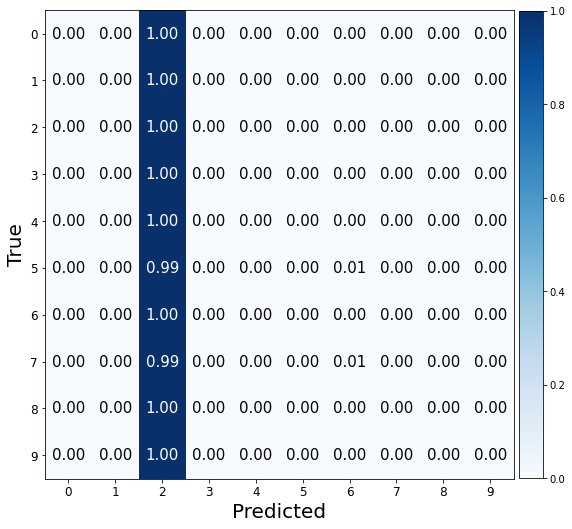

###################

ne: 100, wd:0.1, lr: 0.1, bs:256 
Valid Evaluation loss: 2.3374640941619873. f1:0.056874881388382405 acc: 0.12200000137090683 


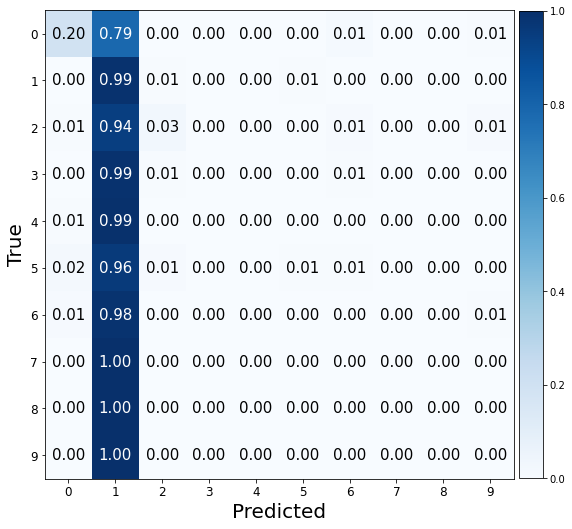

###################

ne: 100, wd:0.001, lr: 0.001, bs:512 
Valid Evaluation loss: 0.26634347438812256. f1:0.9174794215850047 acc: 0.9175000190734863 


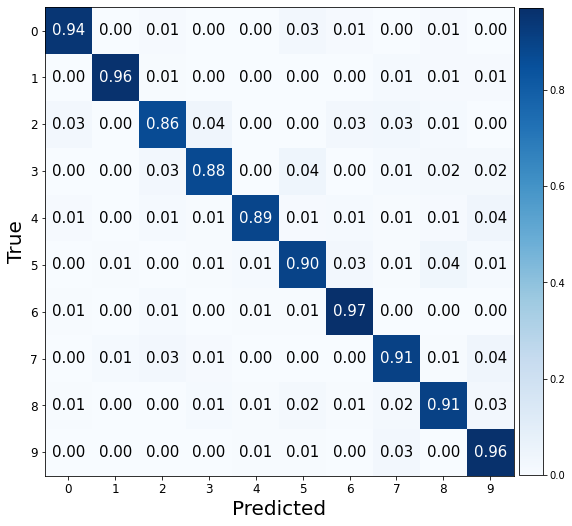

###################

ne: 100, wd:0.01, lr: 0.001, bs:512 
Valid Evaluation loss: 0.3017720580101013. f1:0.9189183100845046 acc: 0.9190000295639038 


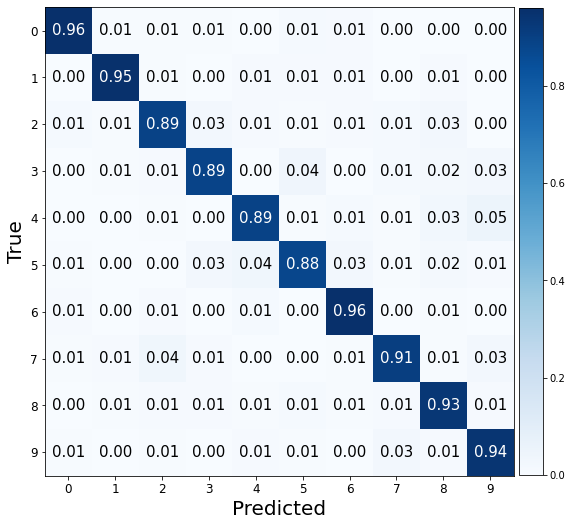

###################

ne: 100, wd:0.1, lr: 0.001, bs:512 
Valid Evaluation loss: 0.29066309332847595. f1:0.9072883279976949 acc: 0.9075000286102295 


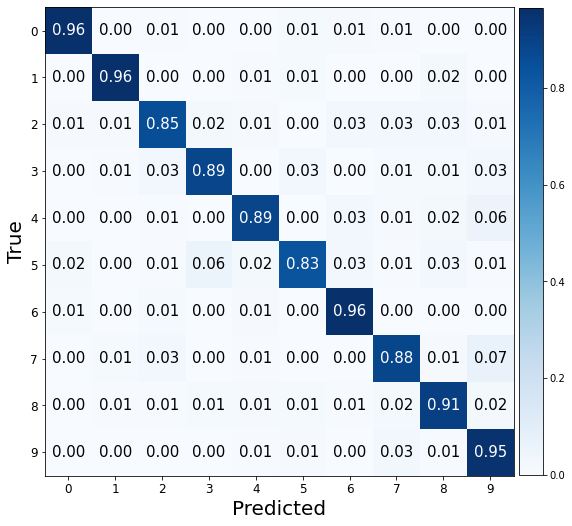

###################

ne: 100, wd:0.001, lr: 0.01, bs:512 
Valid Evaluation loss: 0.6568378210067749. f1:0.8319193598776262 acc: 0.8320000171661377 


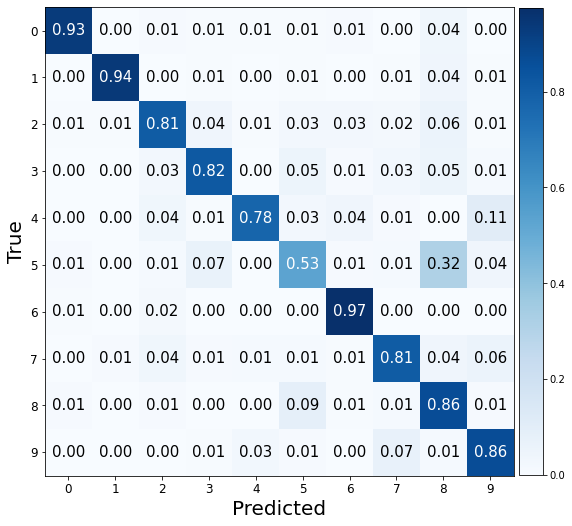

###################

ne: 100, wd:0.01, lr: 0.01, bs:512 
Valid Evaluation loss: 0.5636100172996521. f1:0.8645487618220666 acc: 0.8640000224113464 


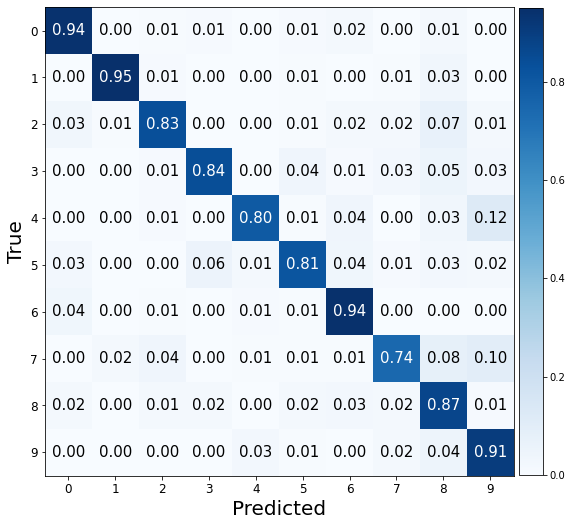

###################

ne: 100, wd:0.1, lr: 0.01, bs:512 
Valid Evaluation loss: 0.3426966667175293. f1:0.9079803802477189 acc: 0.9079999923706055 


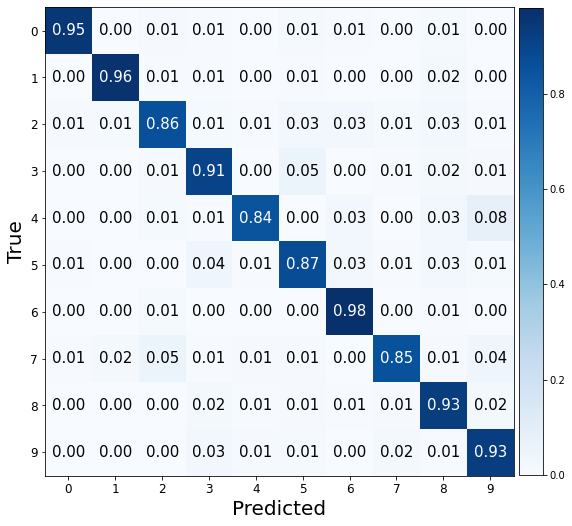

###################

ne: 100, wd:0.001, lr: 0.1, bs:512 
Valid Evaluation loss: 2.3026864528656006. f1:0.01818181818181818 acc: 0.10000000149011612 


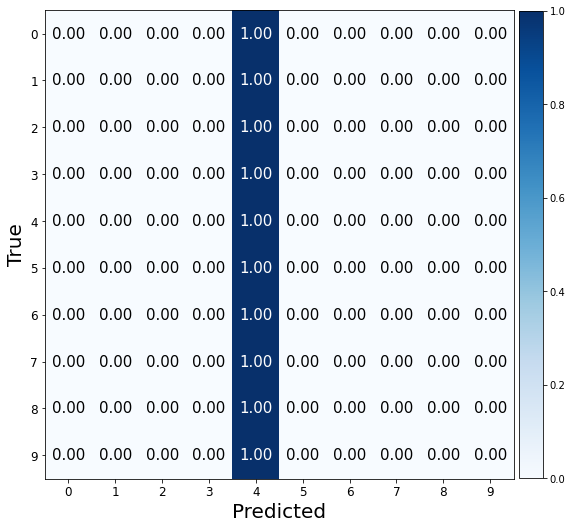

###################

ne: 100, wd:0.01, lr: 0.1, bs:512 
Valid Evaluation loss: 2.3139235973358154. f1:0.018190086402910415 acc: 0.10000000149011612 


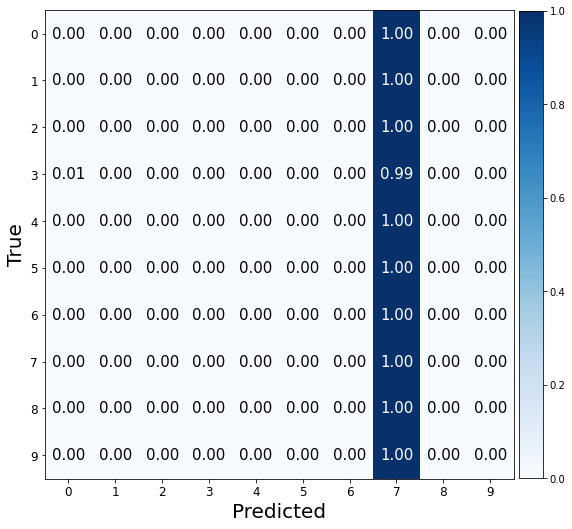

###################

ne: 100, wd:0.1, lr: 0.1, bs:512 
Valid Evaluation loss: 2.4632506370544434. f1:0.02409953596828566 acc: 0.10300000011920929 


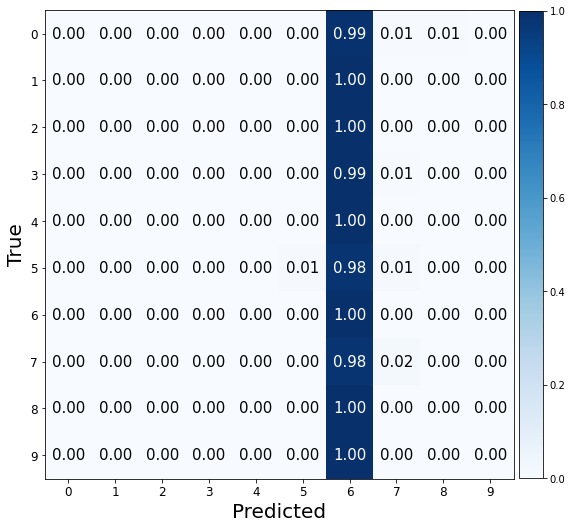

###################

ne: 100, wd:0.001, lr: 0.001, bs:1024 
Valid Evaluation loss: 0.3264209032058716. f1:0.9104011501358696 acc: 0.9104999899864197 


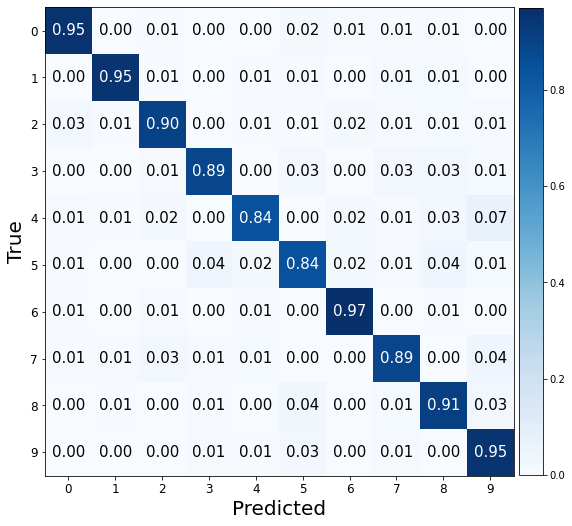

###################

ne: 100, wd:0.01, lr: 0.001, bs:1024 
Valid Evaluation loss: 0.3114323019981384. f1:0.9132348384569436 acc: 0.9135000109672546 


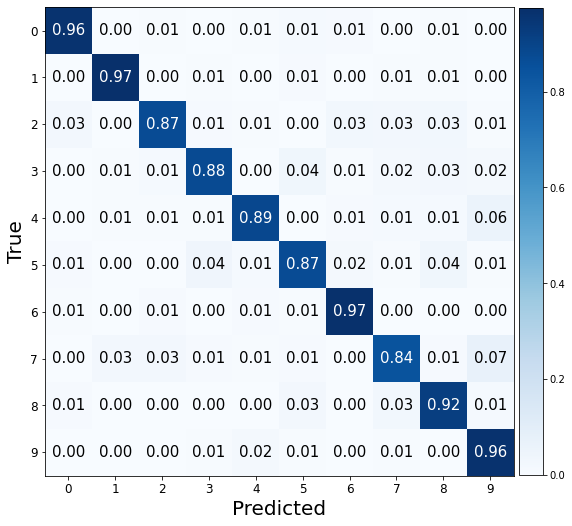

###################

ne: 100, wd:0.1, lr: 0.001, bs:1024 
Valid Evaluation loss: 0.27122369408607483. f1:0.9138136903035085 acc: 0.9139999747276306 


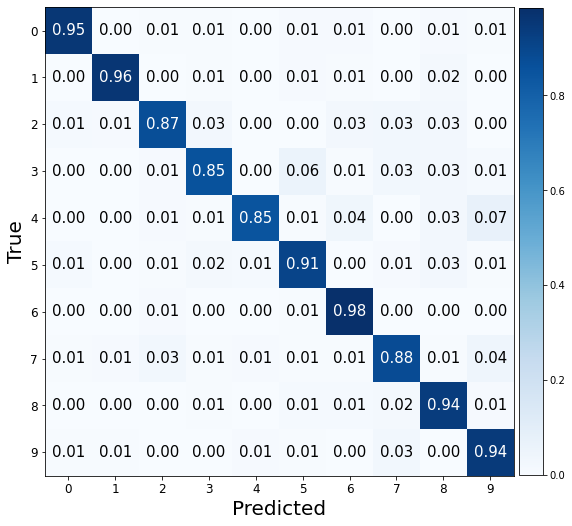

###################

ne: 100, wd:0.001, lr: 0.01, bs:1024 
Valid Evaluation loss: 0.6469737887382507. f1:0.8201799857387669 acc: 0.8209999799728394 


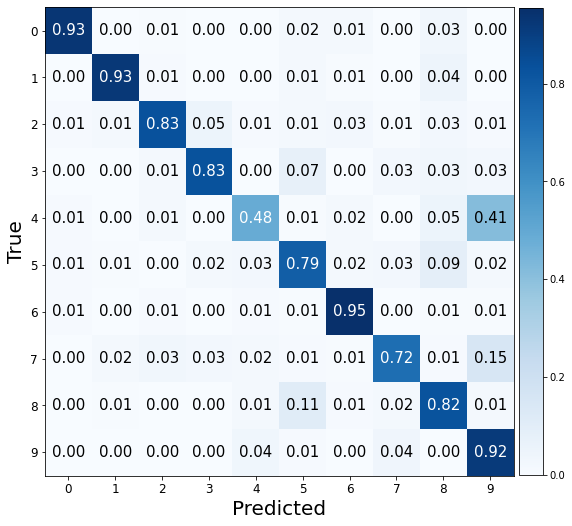

###################

ne: 100, wd:0.01, lr: 0.01, bs:1024 
Valid Evaluation loss: 0.7226672172546387. f1:0.7503277615202875 acc: 0.7515000104904175 


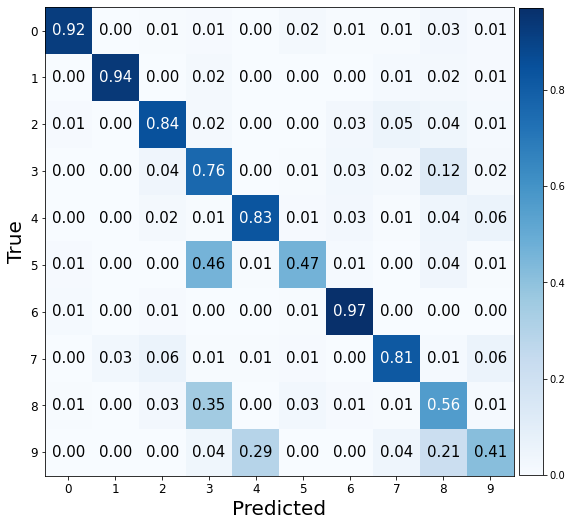

###################

ne: 100, wd:0.1, lr: 0.01, bs:1024 
Valid Evaluation loss: 0.29448339343070984. f1:0.9156415102958718 acc: 0.9160000085830688 


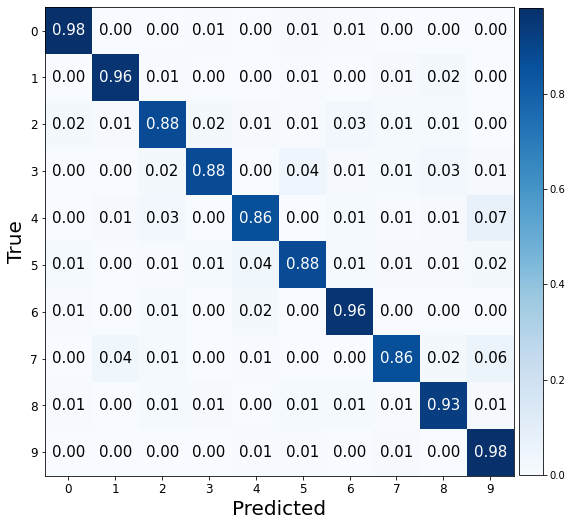

###################

ne: 100, wd:0.001, lr: 0.1, bs:1024 
Valid Evaluation loss: 2.302668571472168. f1:0.01809913597089586 acc: 0.09950000047683716 


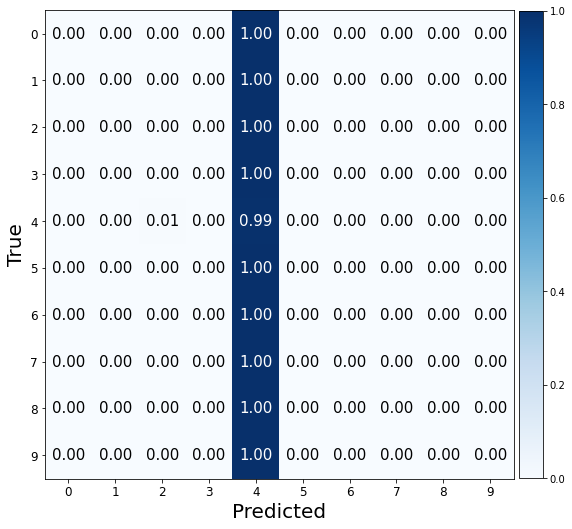

###################

ne: 100, wd:0.01, lr: 0.1, bs:1024 
Valid Evaluation loss: 2.3029372692108154. f1:0.01818181818181818 acc: 0.10000000149011612 


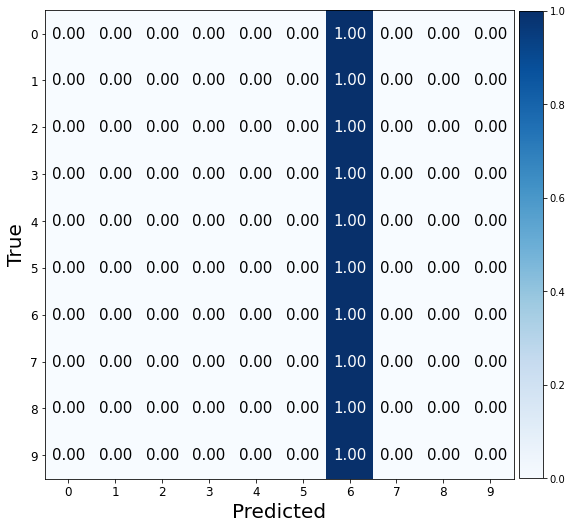

###################

ne: 100, wd:0.1, lr: 0.1, bs:1024 
Valid Evaluation loss: 4.338714122772217. f1:0.030687947979014262 acc: 0.10300000011920929 


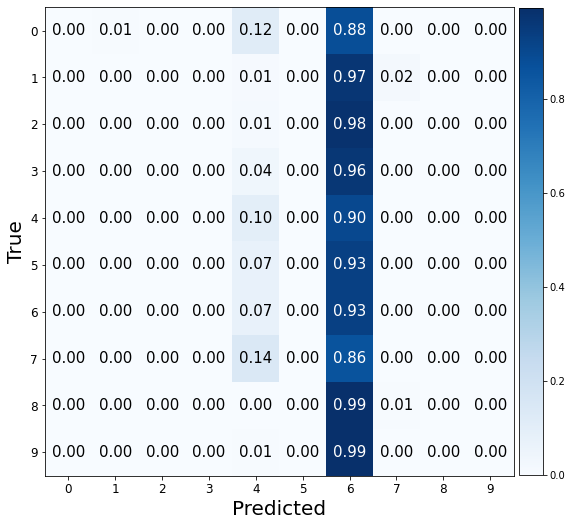

###################

ne: 150, wd:0.001, lr: 0.001, bs:256 
Valid Evaluation loss: 0.34636610746383667. f1:0.9190781322402481 acc: 0.9194999933242798 


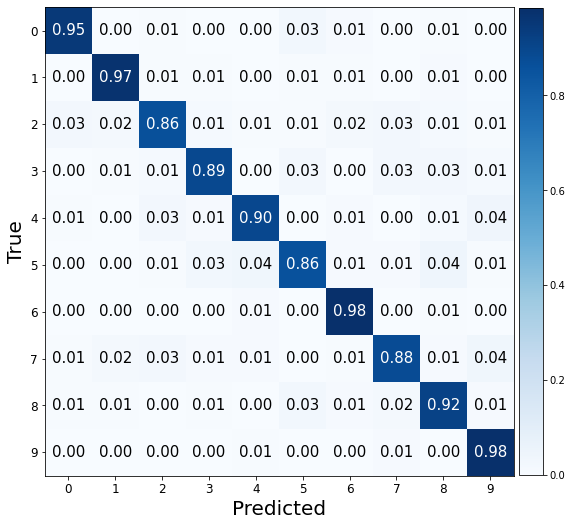

###################

ne: 150, wd:0.01, lr: 0.001, bs:256 
Valid Evaluation loss: 0.3290732800960541. f1:0.9081345317469374 acc: 0.9085000157356262 


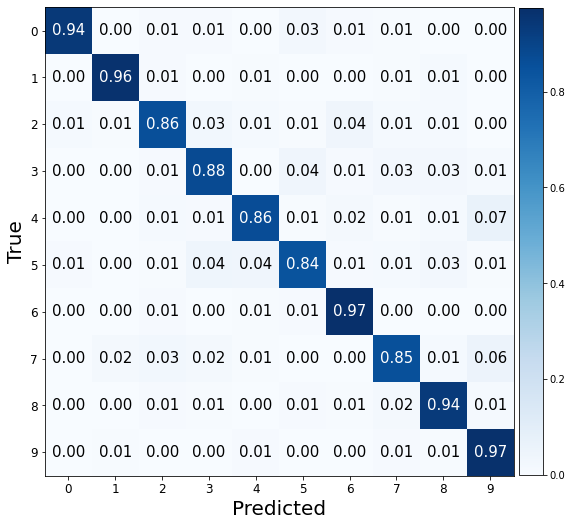

###################

ne: 150, wd:0.1, lr: 0.001, bs:256 
Valid Evaluation loss: 0.2876224219799042. f1:0.9151319399913005 acc: 0.9150000214576721 


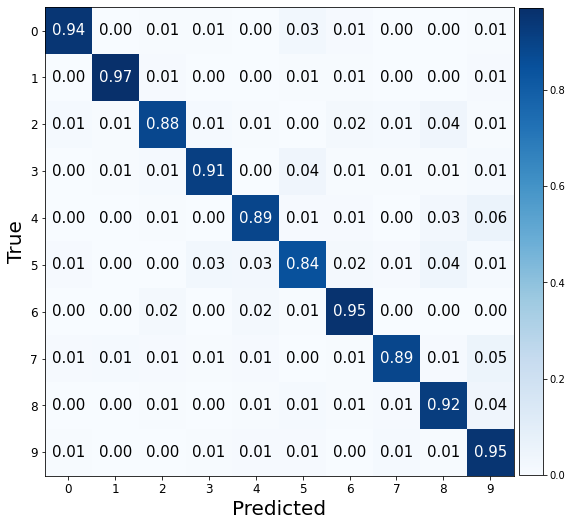

###################

ne: 150, wd:0.001, lr: 0.01, bs:256 
Valid Evaluation loss: 0.5640766620635986. f1:0.864926894989507 acc: 0.8650000095367432 


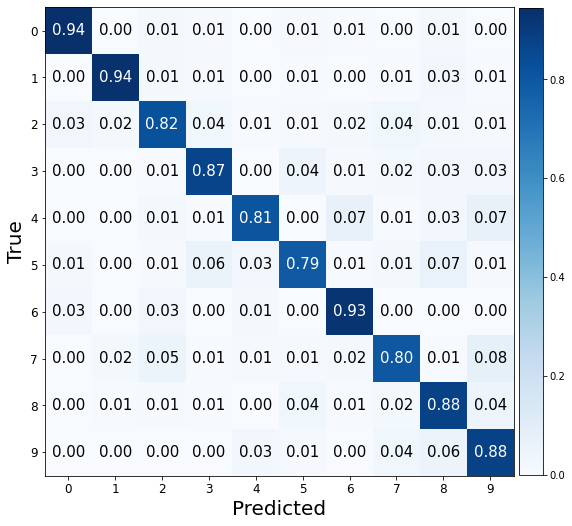

###################

ne: 150, wd:0.01, lr: 0.01, bs:256 
Valid Evaluation loss: 0.5361576080322266. f1:0.8758918572869747 acc: 0.8755000233650208 


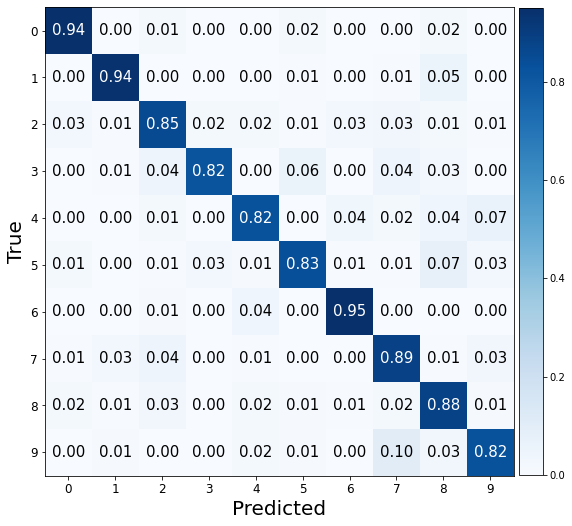

###################

ne: 150, wd:0.1, lr: 0.01, bs:256 
Valid Evaluation loss: 0.3061552941799164. f1:0.910201645010074 acc: 0.9100000262260437 


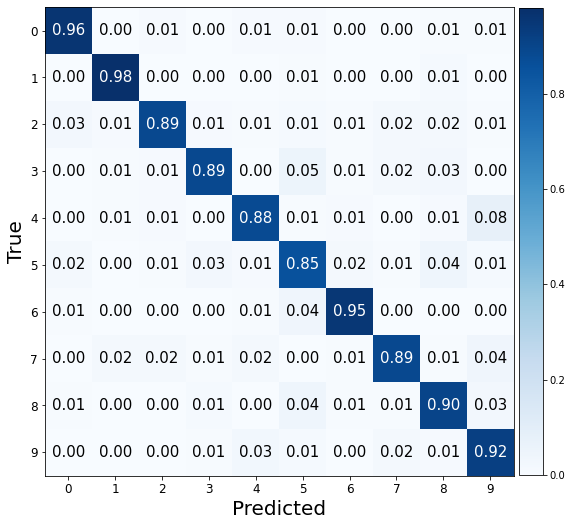

###################

ne: 150, wd:0.001, lr: 0.1, bs:256 
Valid Evaluation loss: 2.302591323852539. f1:0.01818181818181818 acc: 0.10000000149011612 


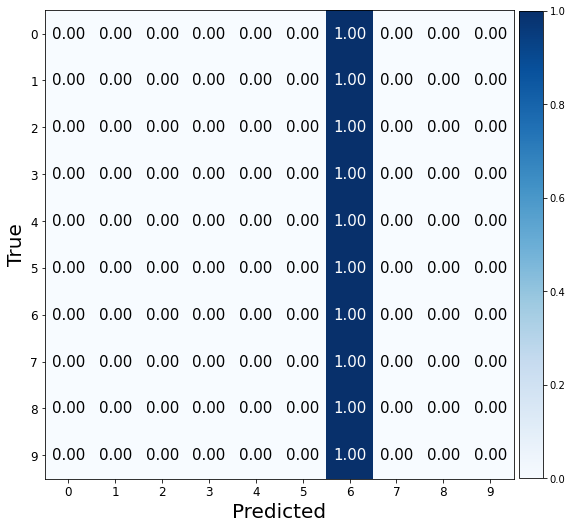

###################

ne: 150, wd:0.01, lr: 0.1, bs:256 
Valid Evaluation loss: 2.3163981437683105. f1:0.01818181818181818 acc: 0.10000000149011612 


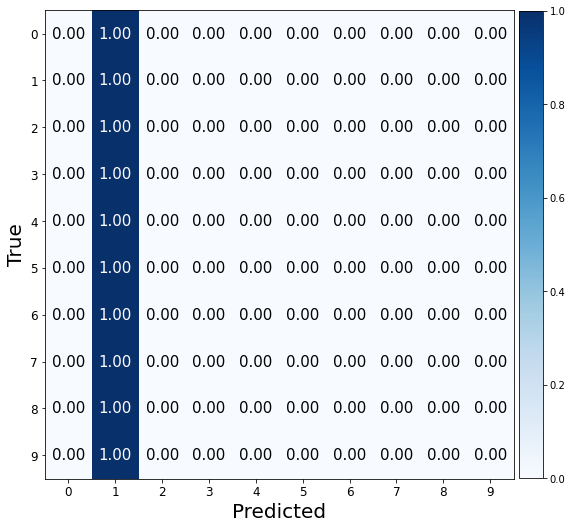

###################

ne: 150, wd:0.1, lr: 0.1, bs:256 
Valid Evaluation loss: 2.3219621181488037. f1:0.03851546340982961 acc: 0.10999999940395355 


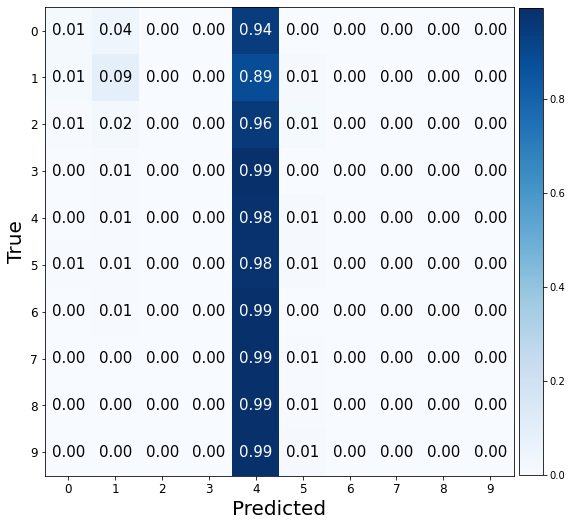

###################

ne: 150, wd:0.001, lr: 0.001, bs:512 
Valid Evaluation loss: 0.378844290971756. f1:0.91074663579245 acc: 0.9110000133514404 


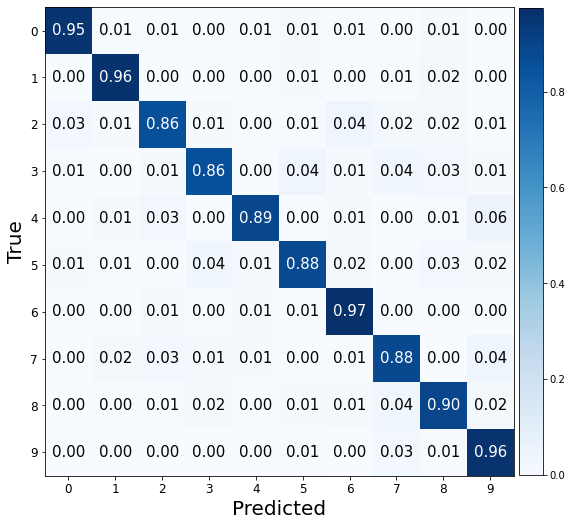

###################

ne: 150, wd:0.01, lr: 0.001, bs:512 
Valid Evaluation loss: 0.3070843517780304. f1:0.9153798003156546 acc: 0.9154999852180481 


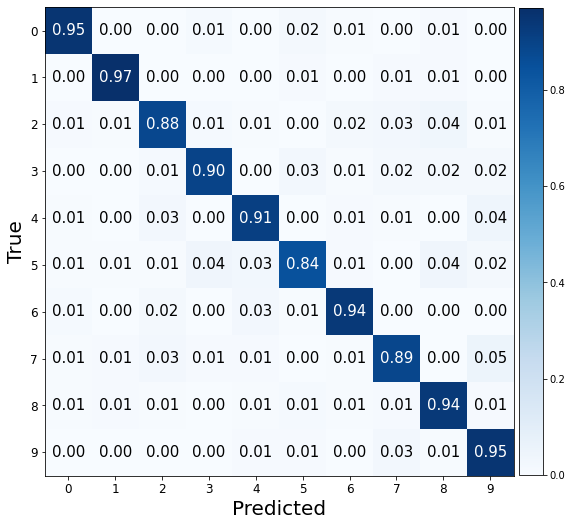

###################

ne: 150, wd:0.1, lr: 0.001, bs:512 
Valid Evaluation loss: 0.2671457529067993. f1:0.9229193482885807 acc: 0.9229999780654907 


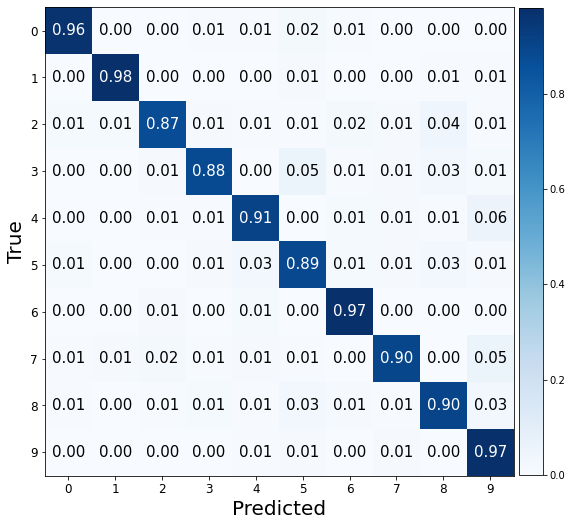

###################

ne: 150, wd:0.001, lr: 0.01, bs:512 
Valid Evaluation loss: 0.5817318558692932. f1:0.8623672011032631 acc: 0.862500011920929 


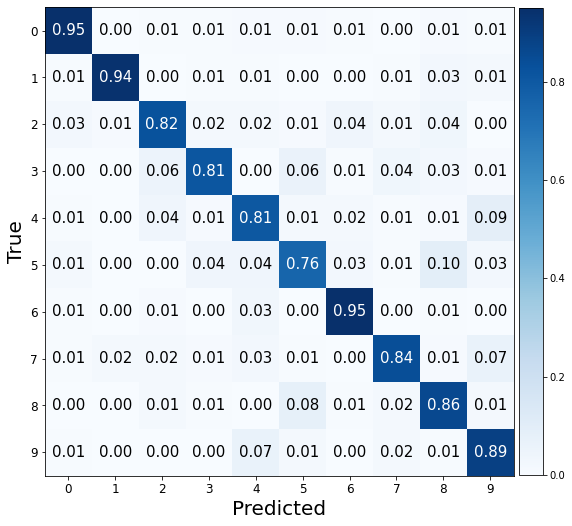

###################

ne: 150, wd:0.01, lr: 0.01, bs:512 
Valid Evaluation loss: 0.38879814743995667. f1:0.8995901478822705 acc: 0.8995000123977661 


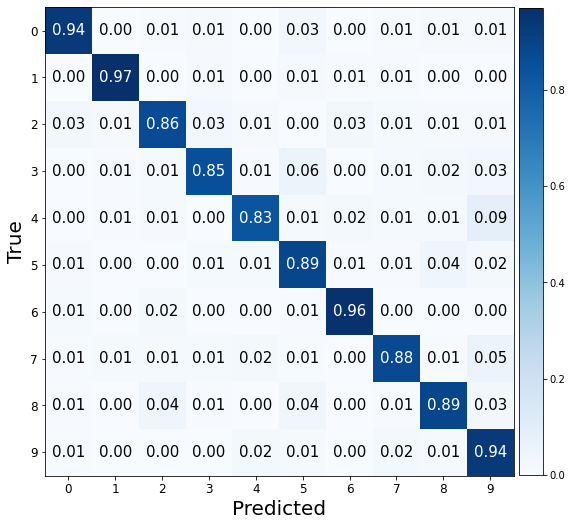

###################

ne: 150, wd:0.1, lr: 0.01, bs:512 
Valid Evaluation loss: 0.28931015729904175. f1:0.9145512324246365 acc: 0.9150000214576721 


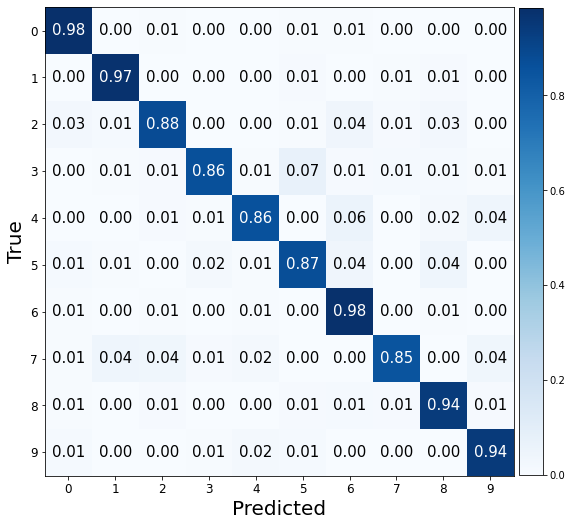

###################

ne: 150, wd:0.001, lr: 0.1, bs:512 
Valid Evaluation loss: 2.3026206493377686. f1:0.01818181818181818 acc: 0.10000000149011612 


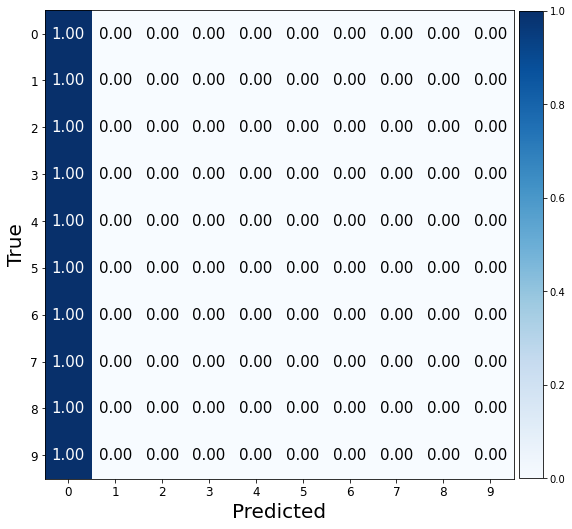

###################

ne: 150, wd:0.01, lr: 0.1, bs:512 
Valid Evaluation loss: 2.2983016967773438. f1:0.01818181818181818 acc: 0.10000000149011612 


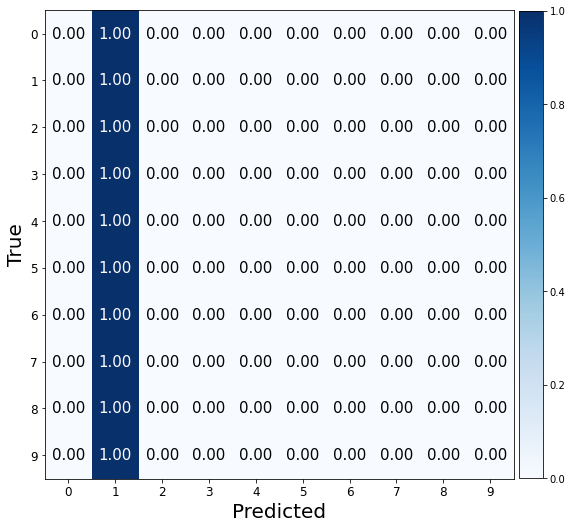

###################

ne: 150, wd:0.1, lr: 0.1, bs:512 
Valid Evaluation loss: 2.3710713386535645. f1:0.022236963907635826 acc: 0.10199999809265137 


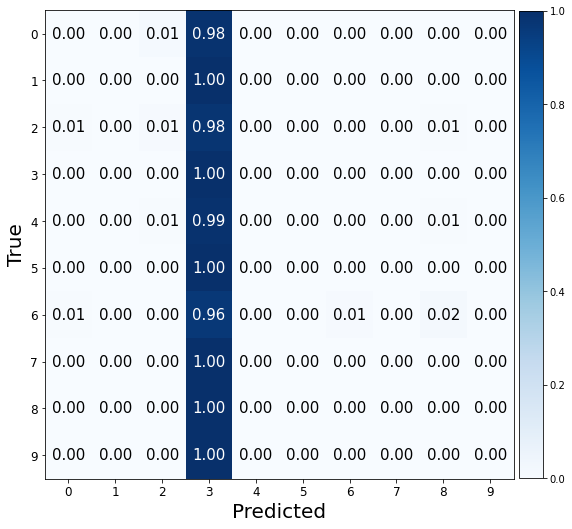

###################

ne: 150, wd:0.001, lr: 0.001, bs:1024 
Valid Evaluation loss: 0.34664708375930786. f1:0.9206974512584211 acc: 0.9210000038146973 


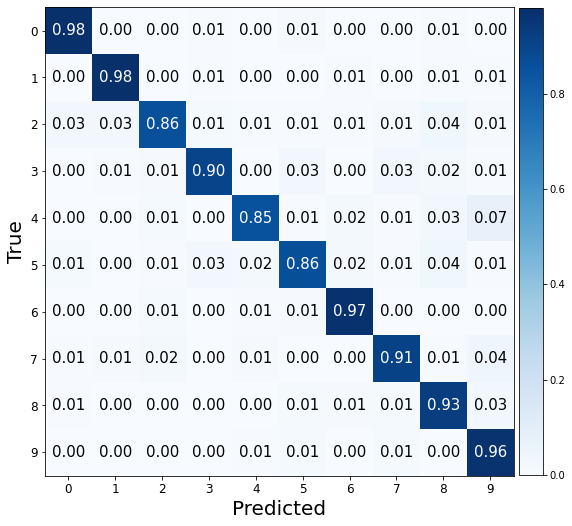

###################

ne: 150, wd:0.01, lr: 0.001, bs:1024 
Valid Evaluation loss: 0.31701189279556274. f1:0.9149808689060013 acc: 0.9150000214576721 


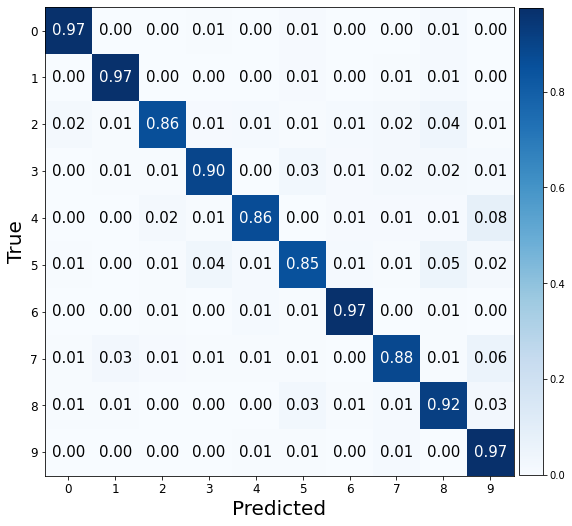

###################

ne: 150, wd:0.1, lr: 0.001, bs:1024 
Valid Evaluation loss: 0.2729951739311218. f1:0.9127946328643418 acc: 0.9129999876022339 


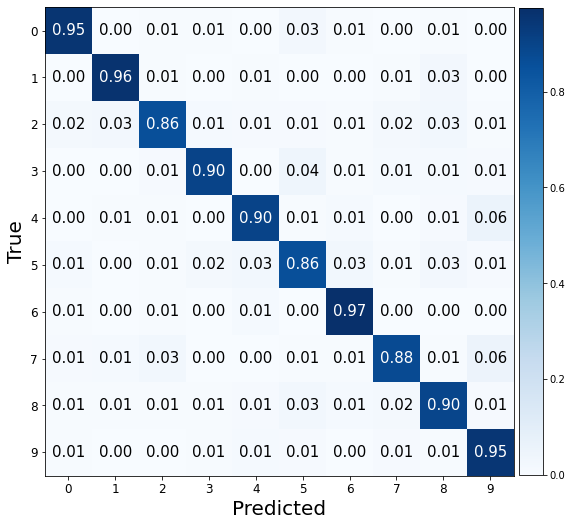

###################

ne: 150, wd:0.001, lr: 0.01, bs:1024 
Valid Evaluation loss: 0.8337862491607666. f1:0.7212002230482446 acc: 0.7419999837875366 


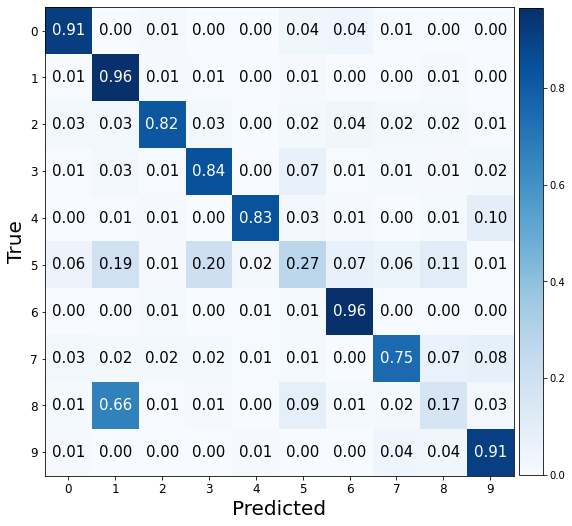

###################

ne: 150, wd:0.01, lr: 0.01, bs:1024 
Valid Evaluation loss: 0.5300582051277161. f1:0.8742017788431573 acc: 0.8744999766349792 


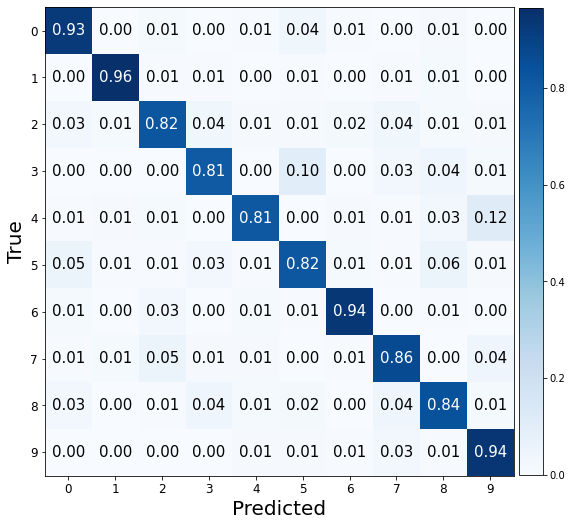

###################

ne: 150, wd:0.1, lr: 0.01, bs:1024 
Valid Evaluation loss: 0.44639167189598083. f1:0.8631523531047526 acc: 0.8629999756813049 


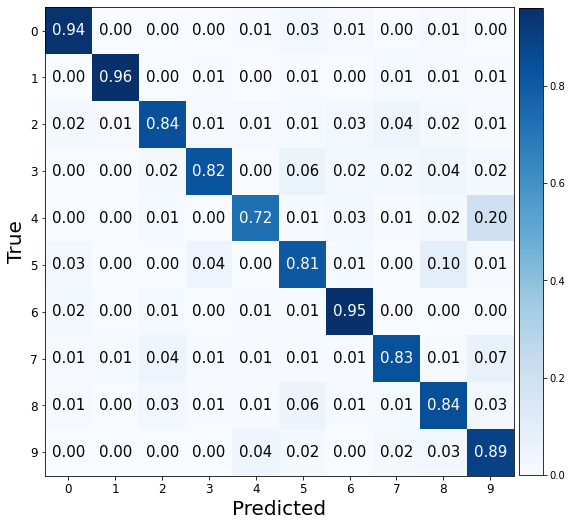

###################

ne: 150, wd:0.001, lr: 0.1, bs:1024 
Valid Evaluation loss: 2.3027164936065674. f1:0.01818181818181818 acc: 0.10000000149011612 


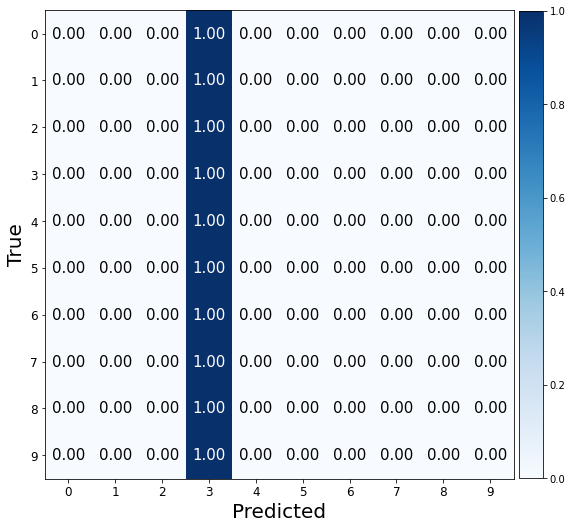

###################

ne: 150, wd:0.01, lr: 0.1, bs:1024 
Valid Evaluation loss: 2.3229970932006836. f1:0.01818181818181818 acc: 0.10000000149011612 


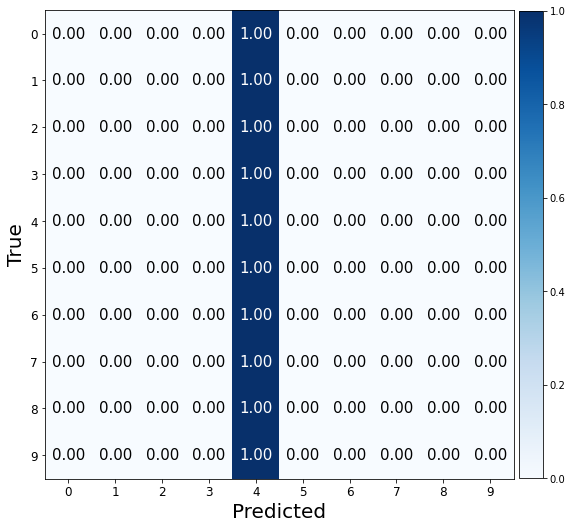

###################

ne: 150, wd:0.1, lr: 0.1, bs:1024 
Valid Evaluation loss: 2.2213940620422363. f1:0.09493884146918005 acc: 0.164000004529953 


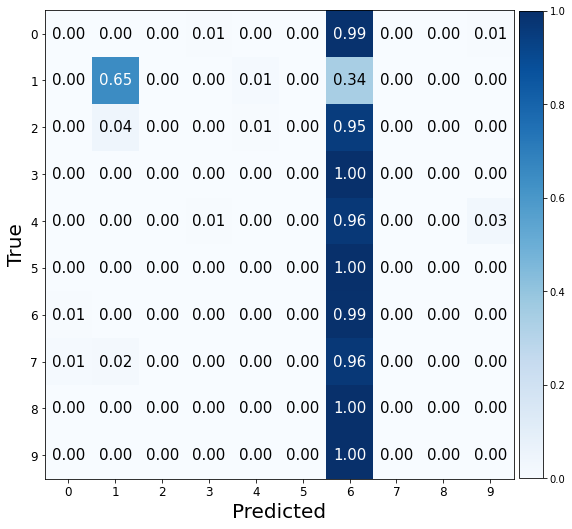

###################



In [38]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

ne_list = [50,100,150]
lr_list = [0.001,0.01,0.1]
wd_list = [0.001,0.01,0.1]
bs_list = [256,512,1024]

dict_f1 = {}      #Definimos un dict_f1 para guardar el f1 de cada modelo y luego encontrar rápidamente el que tiene un mejor aprendizaje

pbar = tqdm(total=len(bs_list)*len(lr_list)*len(wd_list)*len(ne_list))

for ne in ne_list:
  for bs in bs_list:
    train_ds = TensorDataset(X_train, Y_train)
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

    for lr in lr_list:
      for wd in wd_list:
        input_dim = 28*28
        out_dim = 10
        hidden = 100

        model = torch.nn.Sequential(
          torch.nn.Linear(input_dim, hidden),
          torch.nn.ReLU(),
          torch.nn.Linear(hidden, hidden),
          torch.nn.ReLU(),
          torch.nn.Linear(hidden, out_dim)
        )

        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        criterion = torch.nn.CrossEntropyLoss()

        print('ne: {}, wd:{}, lr: {}, bs:{} '.format(ne,wd,lr,bs))
        f1, matrix = train_valid(model,ne,optimizer,criterion)
        print('###################\n')
        pbar.update()

      dict_f1[f1] = [ne, lr, wd, bs, matrix]
pbar.close()

### Utilizamos el diccionario para hallar los parámetros y la matrix de confusión del f1 máximo

f1_max:0.9229, n_epoch:150, lr:0.001, weight_decay:0.1, batch_size:512 


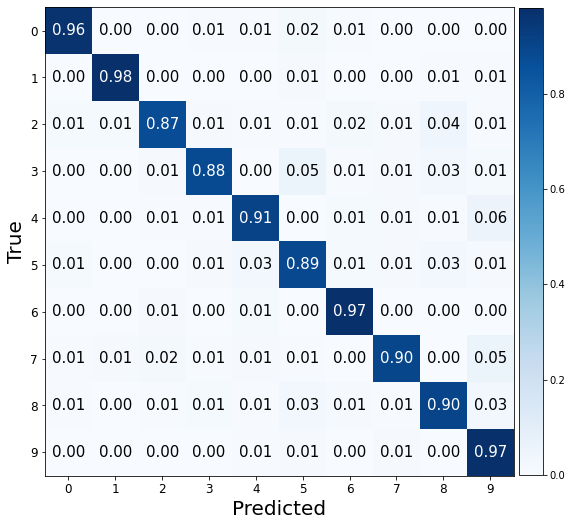

In [39]:
#Llamamos al máximo de f1_dict

f1_max = max(dict_f1.keys())
print("f1_max:{:.4f}, n_epoch:{}, lr:{}, weight_decay:{}, batch_size:{} ".format(f1_max,*dict_f1[f1_max][:4]))

dict_f1[f1_max][-1]

Creamos ahora el segundo modelo con 50 neuronas ocultas y 3 capas, y corremos su aprendizaje evaluándolo con la matriz de confusión.

  0%|          | 0/81 [00:00<?, ?it/s]

ne: 50, wd:0.001, lr: 0.001, bs:256 
Valid Evaluation loss: 0.7694800496101379. f1:0.8276994674355965 acc: 0.828499972820282 


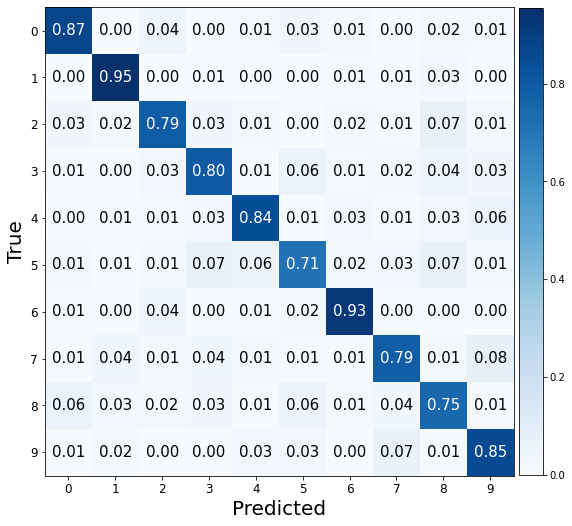

###################

ne: 50, wd:0.01, lr: 0.001, bs:256 
Valid Evaluation loss: 0.8991447687149048. f1:0.8360161322970485 acc: 0.8360000252723694 


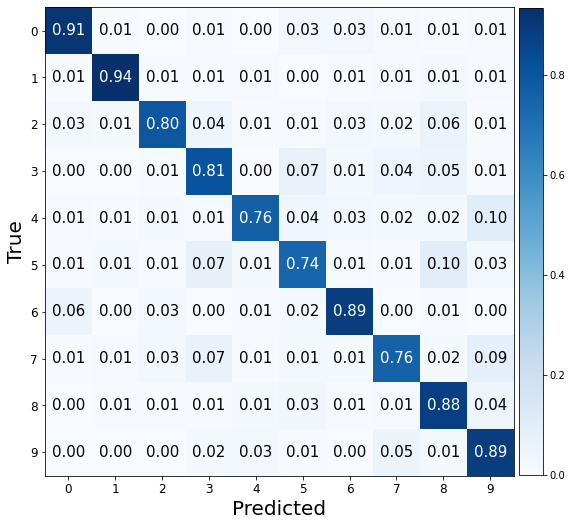

###################

ne: 50, wd:0.1, lr: 0.001, bs:256 
Valid Evaluation loss: 0.74847412109375. f1:0.8280812096542753 acc: 0.828000009059906 


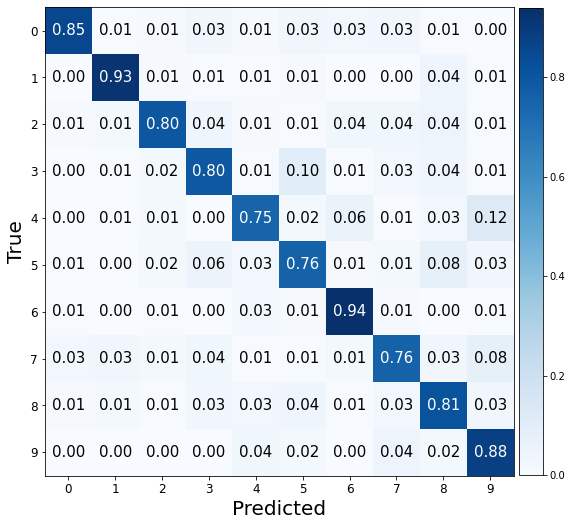

###################

ne: 50, wd:0.001, lr: 0.01, bs:256 
Valid Evaluation loss: 1.428941249847412. f1:0.634520593595509 acc: 0.6334999799728394 


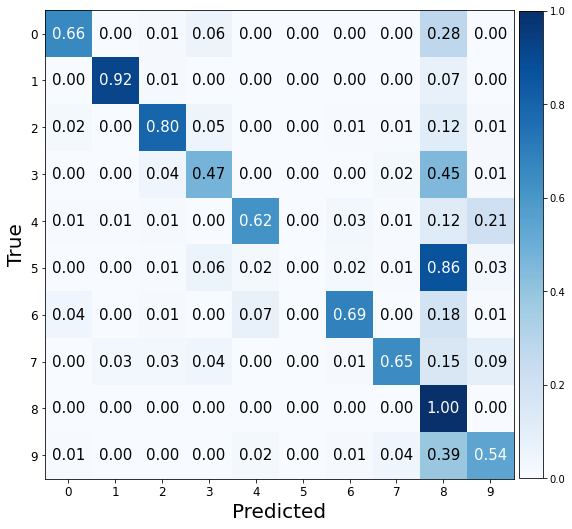

###################

ne: 50, wd:0.01, lr: 0.01, bs:256 
Valid Evaluation loss: 1.4512543678283691. f1:0.512433667078853 acc: 0.531000018119812 


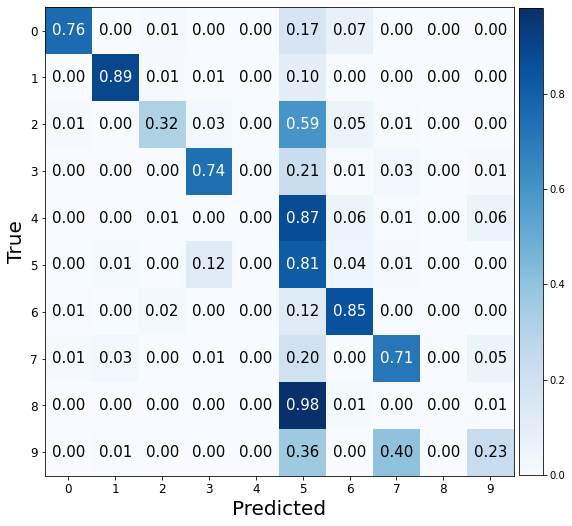

###################

ne: 50, wd:0.1, lr: 0.01, bs:256 
Valid Evaluation loss: 1.628515601158142. f1:0.43328836409508636 acc: 0.4715000092983246 


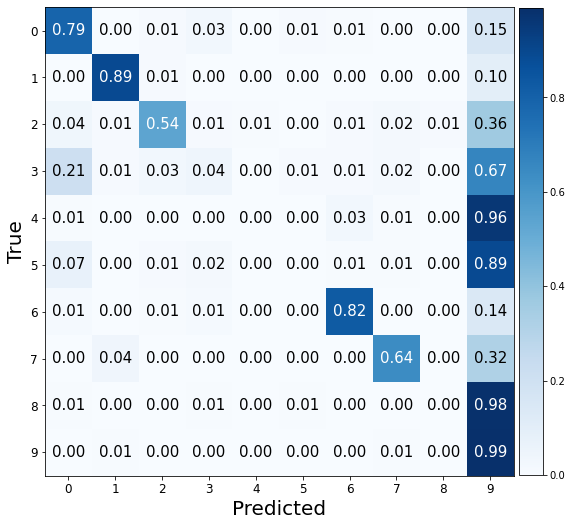

###################

ne: 50, wd:0.001, lr: 0.1, bs:256 
Valid Evaluation loss: 2.1878464221954346. f1:0.08853393336823431 acc: 0.14650000631809235 


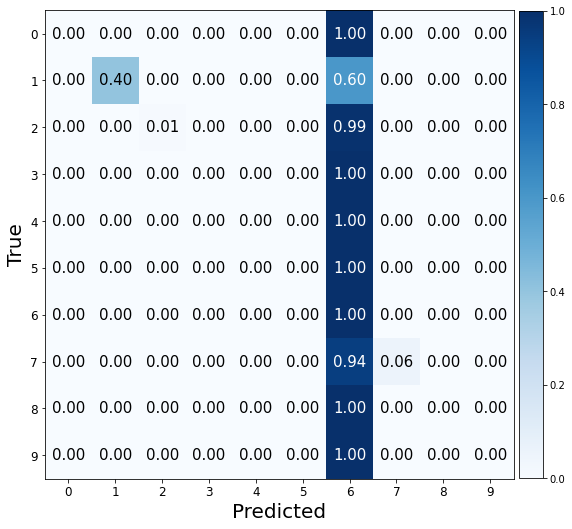

###################

ne: 50, wd:0.01, lr: 0.1, bs:256 
Valid Evaluation loss: 2.1702768802642822. f1:0.08706166754014458 acc: 0.15150000154972076 


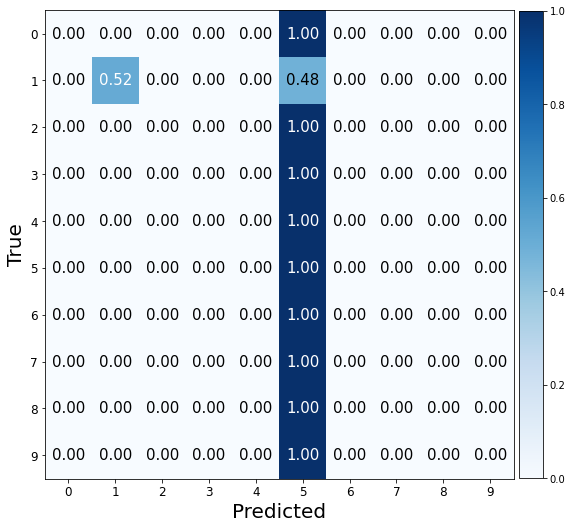

###################

ne: 50, wd:0.1, lr: 0.1, bs:256 
Valid Evaluation loss: 2.4285225868225098. f1:0.13837249355444484 acc: 0.19499999284744263 


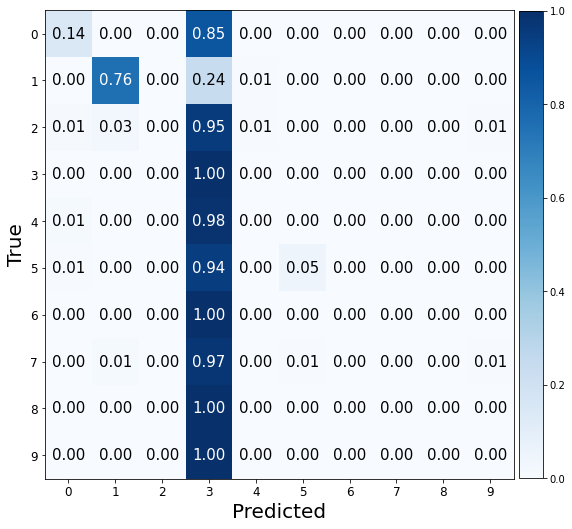

###################

ne: 50, wd:0.001, lr: 0.001, bs:512 
Valid Evaluation loss: 0.863210916519165. f1:0.8125865342822178 acc: 0.8130000233650208 


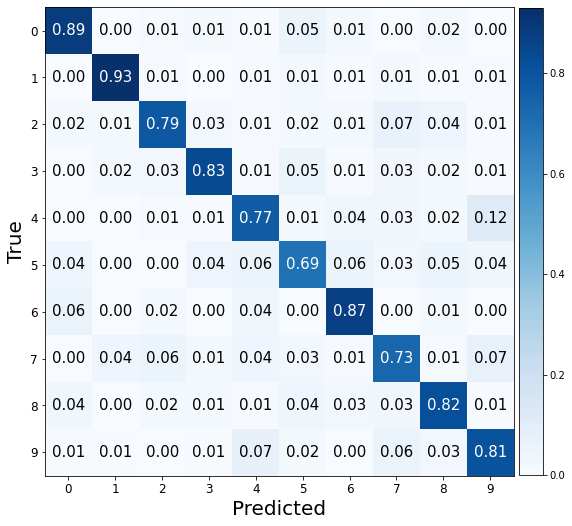

###################

ne: 50, wd:0.01, lr: 0.001, bs:512 
Valid Evaluation loss: 0.8843448162078857. f1:0.812911272571875 acc: 0.8130000233650208 


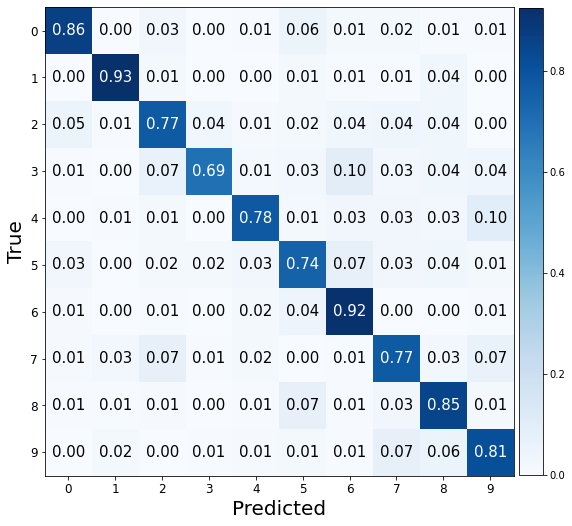

###################

ne: 50, wd:0.1, lr: 0.001, bs:512 
Valid Evaluation loss: 0.8724579811096191. f1:0.8283306529235805 acc: 0.828499972820282 


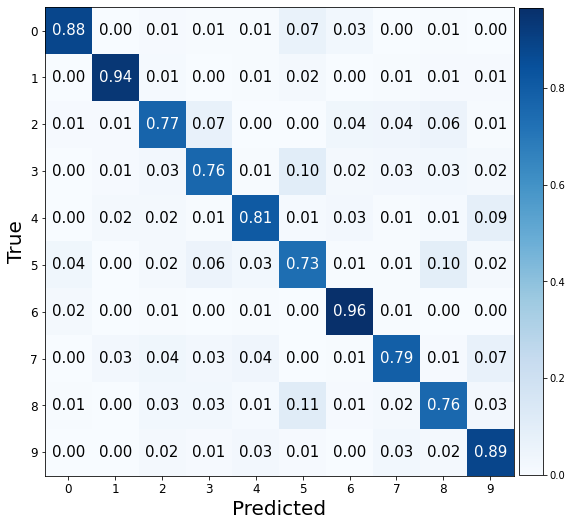

###################

ne: 50, wd:0.001, lr: 0.01, bs:512 
Valid Evaluation loss: 1.3761869668960571. f1:0.5557103999997683 acc: 0.5665000081062317 


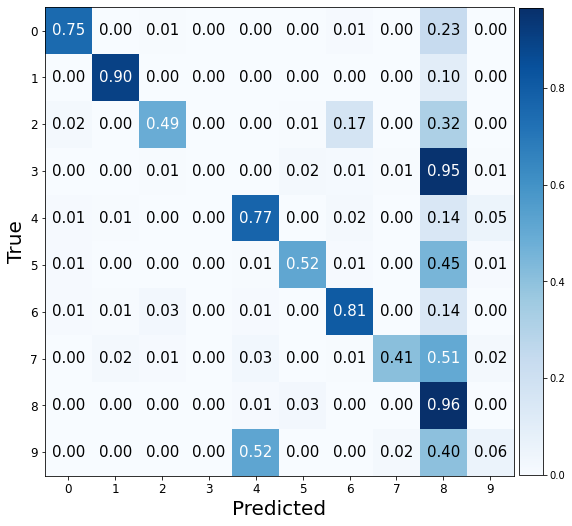

###################

ne: 50, wd:0.01, lr: 0.01, bs:512 
Valid Evaluation loss: 1.9339969158172607. f1:0.2984834562451476 acc: 0.3244999945163727 


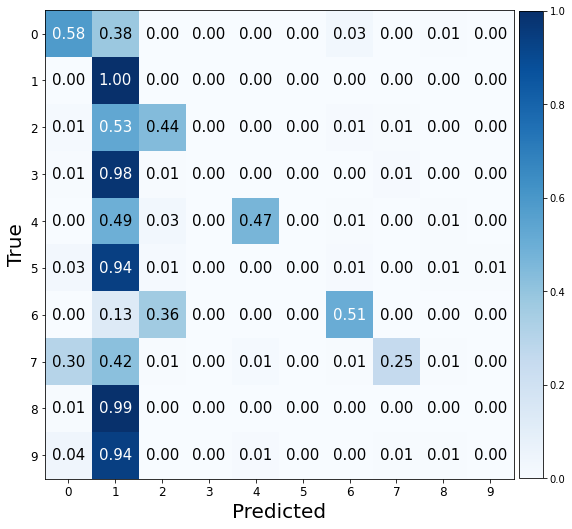

###################

ne: 50, wd:0.1, lr: 0.01, bs:512 
Valid Evaluation loss: 1.758192539215088. f1:0.4082664276192796 acc: 0.4154999852180481 


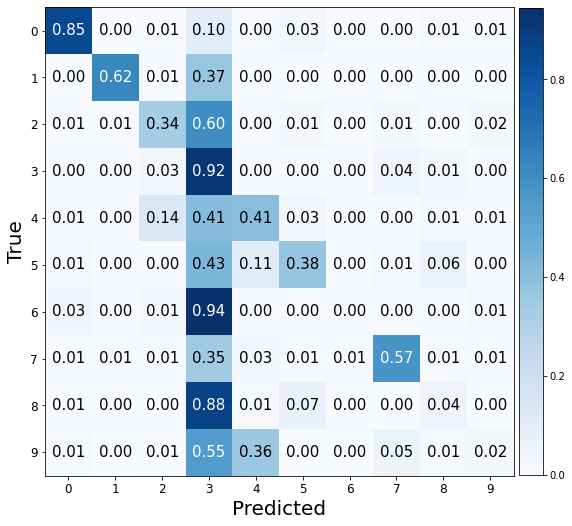

###################

ne: 50, wd:0.001, lr: 0.1, bs:512 
Valid Evaluation loss: 2.8681576251983643. f1:0.15436704648765295 acc: 0.21150000393390656 


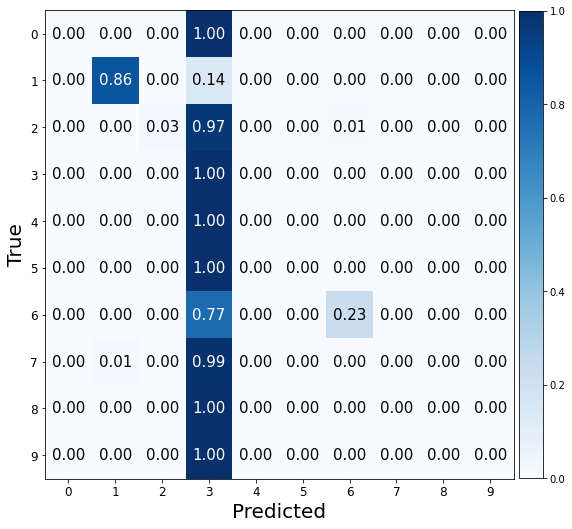

###################

ne: 50, wd:0.01, lr: 0.1, bs:512 
Valid Evaluation loss: 2.265110969543457. f1:0.06834529065196193 acc: 0.12950000166893005 


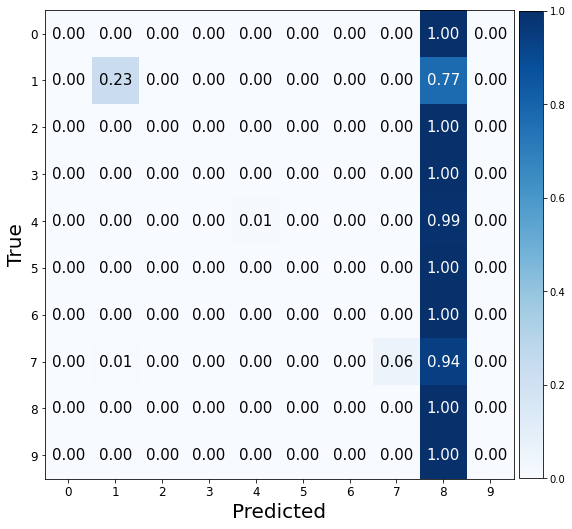

###################

ne: 50, wd:0.1, lr: 0.1, bs:512 
Valid Evaluation loss: 2.3101065158843994. f1:0.02376487410426665 acc: 0.10300000011920929 


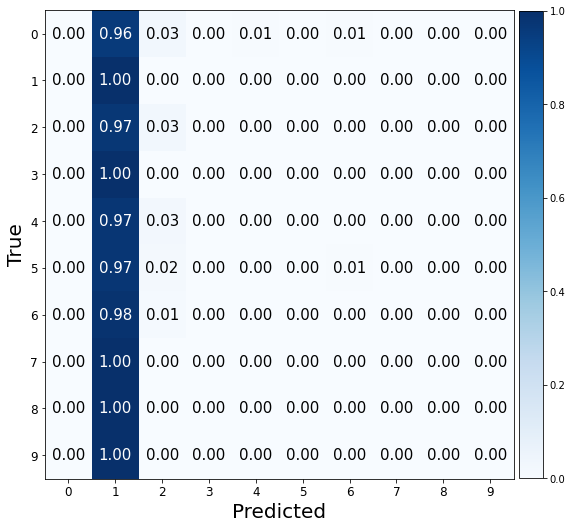

###################

ne: 50, wd:0.001, lr: 0.001, bs:1024 
Valid Evaluation loss: 0.7639563083648682. f1:0.8419611392119164 acc: 0.8414999842643738 


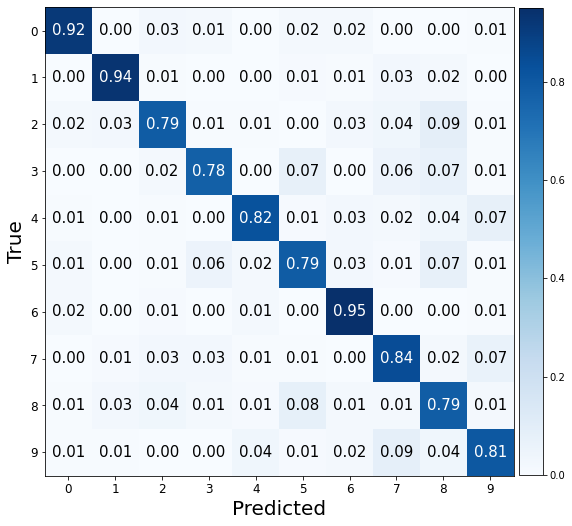

###################

ne: 50, wd:0.01, lr: 0.001, bs:1024 
Valid Evaluation loss: 0.7761663198471069. f1:0.8295439021913186 acc: 0.8299999833106995 


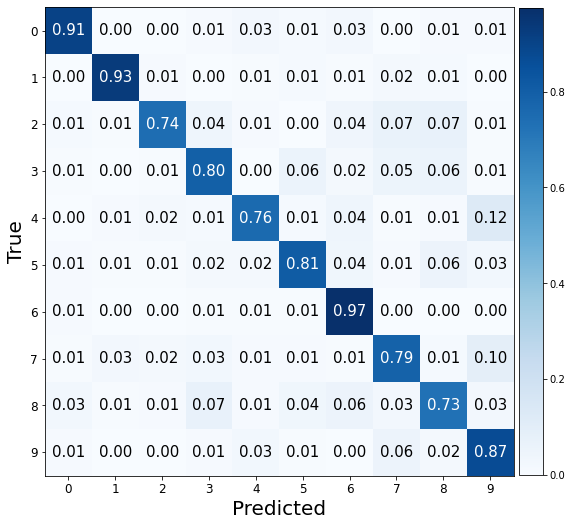

###################

ne: 50, wd:0.1, lr: 0.001, bs:1024 
Valid Evaluation loss: 0.9599783420562744. f1:0.7996311377317806 acc: 0.7990000247955322 


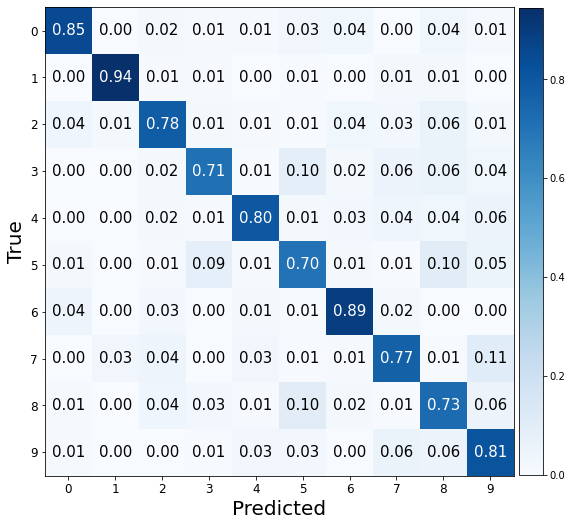

###################

ne: 50, wd:0.001, lr: 0.01, bs:1024 
Valid Evaluation loss: 1.598373532295227. f1:0.4470826468556755 acc: 0.46799999475479126 


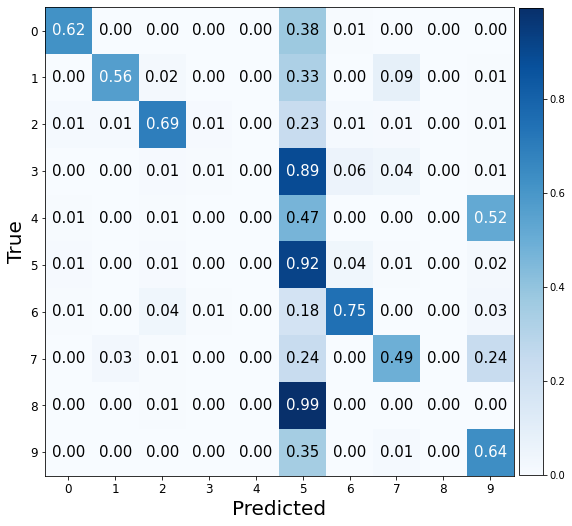

###################

ne: 50, wd:0.01, lr: 0.01, bs:1024 
Valid Evaluation loss: 1.7292977571487427. f1:0.42910067390262546 acc: 0.4230000078678131 


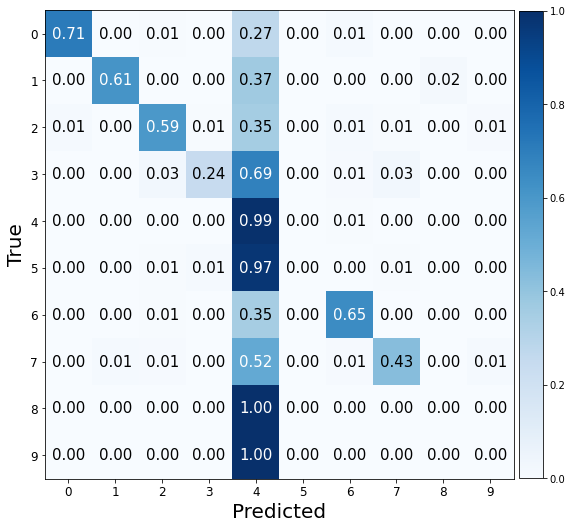

###################

ne: 50, wd:0.1, lr: 0.01, bs:1024 
Valid Evaluation loss: 1.5543396472930908. f1:0.4015335971638866 acc: 0.44749999046325684 


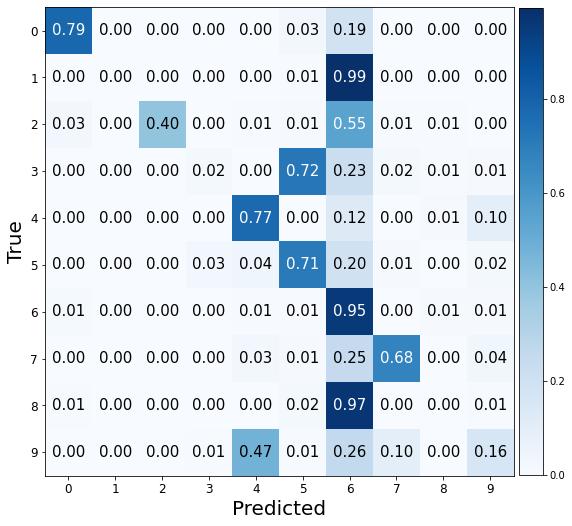

###################

ne: 50, wd:0.001, lr: 0.1, bs:1024 
Valid Evaluation loss: 2.413778305053711. f1:0.10436243116041628 acc: 0.17249999940395355 


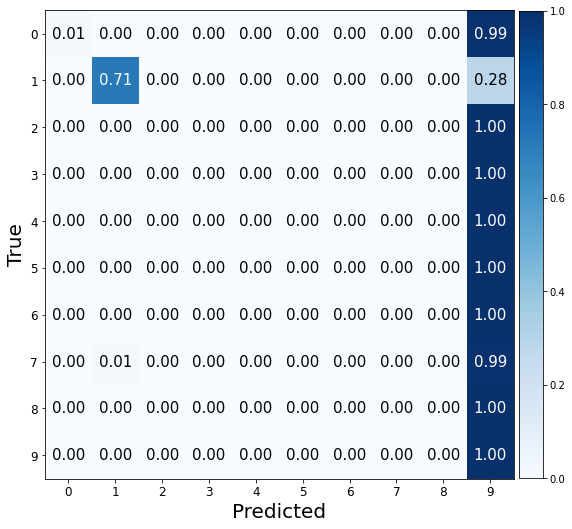

###################

ne: 50, wd:0.01, lr: 0.1, bs:1024 
Valid Evaluation loss: 2.4261889457702637. f1:0.018190086402910415 acc: 0.10000000149011612 


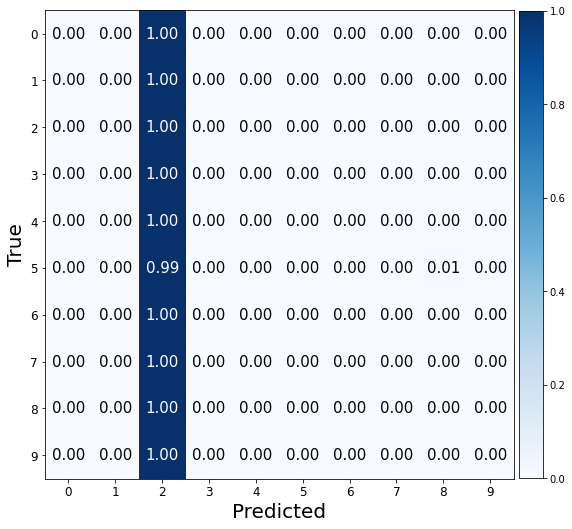

###################

ne: 50, wd:0.1, lr: 0.1, bs:1024 
Valid Evaluation loss: 2.215898036956787. f1:0.08376572896599316 acc: 0.1404999941587448 


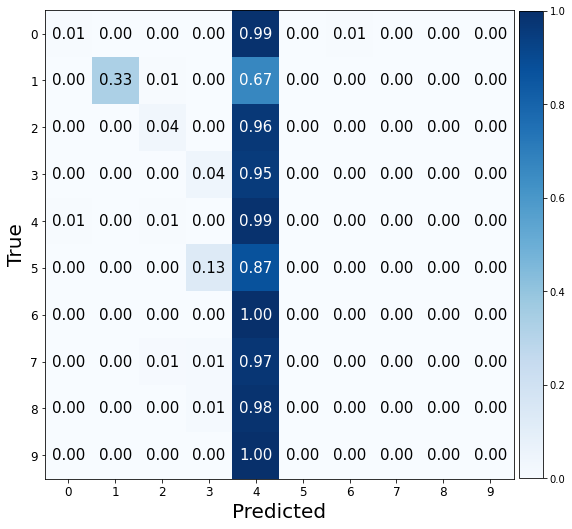

###################

ne: 100, wd:0.001, lr: 0.001, bs:256 
Valid Evaluation loss: 0.7910386919975281. f1:0.8484077988507999 acc: 0.8485000133514404 


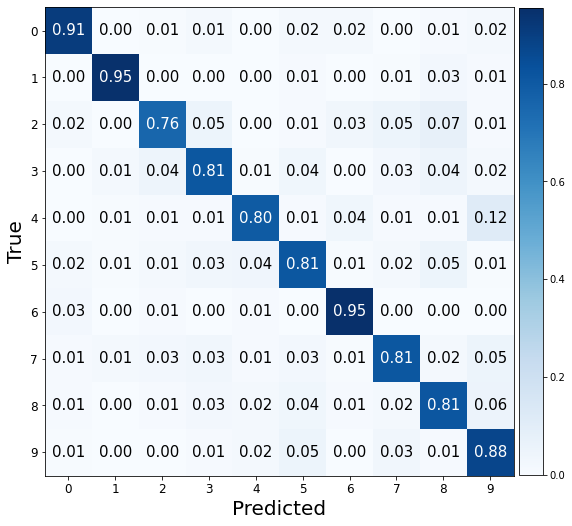

###################

ne: 100, wd:0.01, lr: 0.001, bs:256 
Valid Evaluation loss: 0.7312522530555725. f1:0.8235789608827122 acc: 0.8234999775886536 


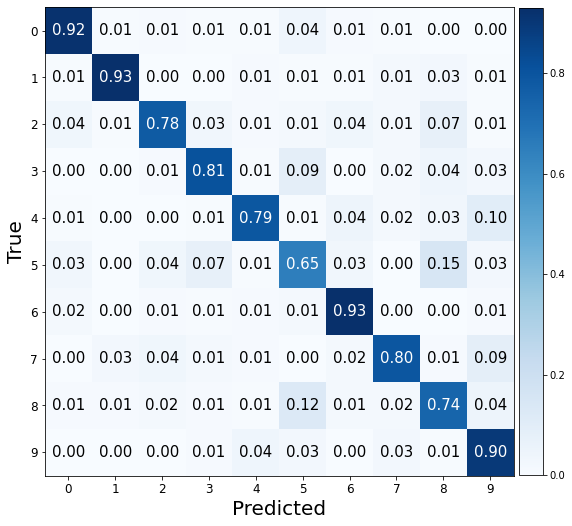

###################

ne: 100, wd:0.1, lr: 0.001, bs:256 
Valid Evaluation loss: 0.593490719795227. f1:0.855455272840044 acc: 0.8554999828338623 


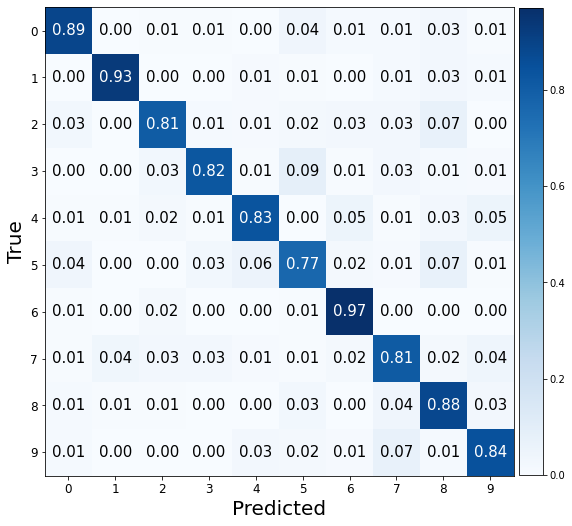

###################

ne: 100, wd:0.001, lr: 0.01, bs:256 
Valid Evaluation loss: 1.5976850986480713. f1:0.4713452276573505 acc: 0.4880000054836273 


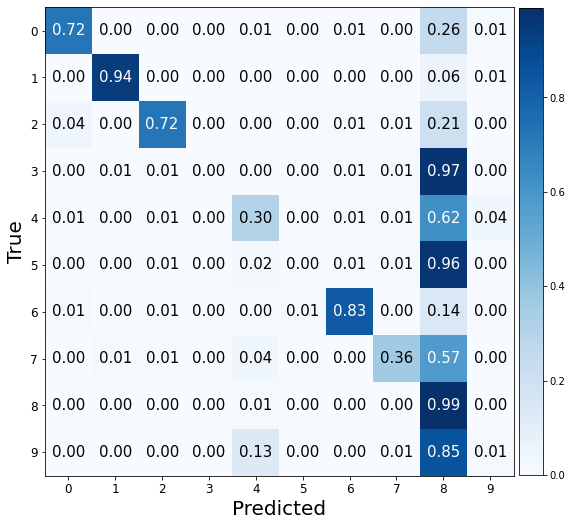

###################

ne: 100, wd:0.01, lr: 0.01, bs:256 
Valid Evaluation loss: 1.4108023643493652. f1:0.49611267001237164 acc: 0.5329999923706055 


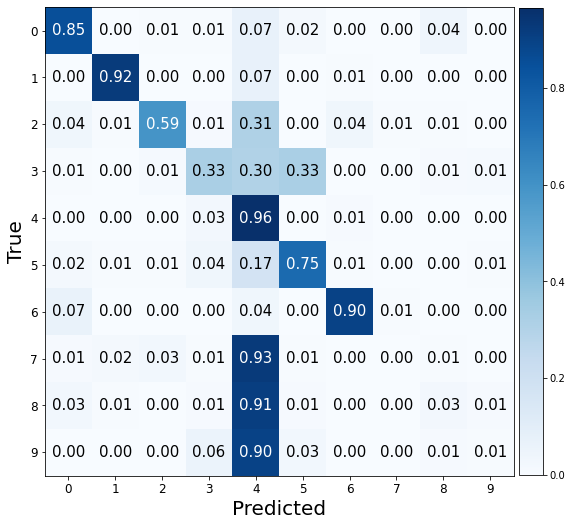

###################

ne: 100, wd:0.1, lr: 0.01, bs:256 
Valid Evaluation loss: 1.3079936504364014. f1:0.5404818922962741 acc: 0.574999988079071 


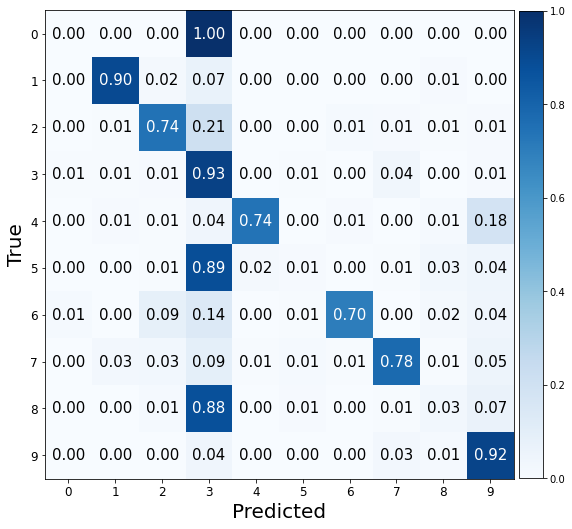

###################

ne: 100, wd:0.001, lr: 0.1, bs:256 
Valid Evaluation loss: 3.3149399757385254. f1:0.134602657608736 acc: 0.18000000715255737 


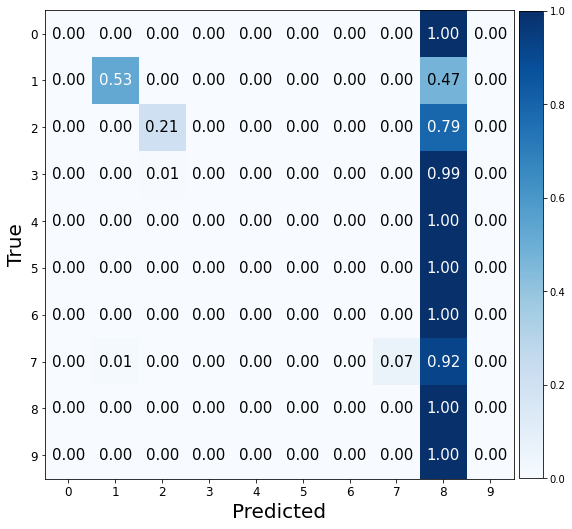

###################

ne: 100, wd:0.01, lr: 0.1, bs:256 
Valid Evaluation loss: 2.9195752143859863. f1:0.10276209799740325 acc: 0.16699999570846558 


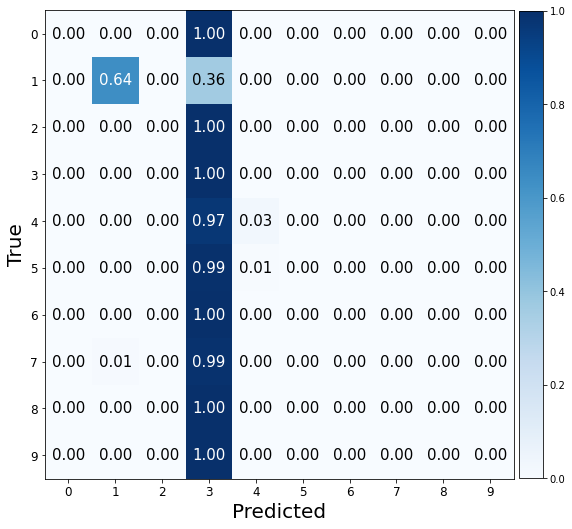

###################

ne: 100, wd:0.1, lr: 0.1, bs:256 
Valid Evaluation loss: 4.067134857177734. f1:0.07138039481242282 acc: 0.17350000143051147 


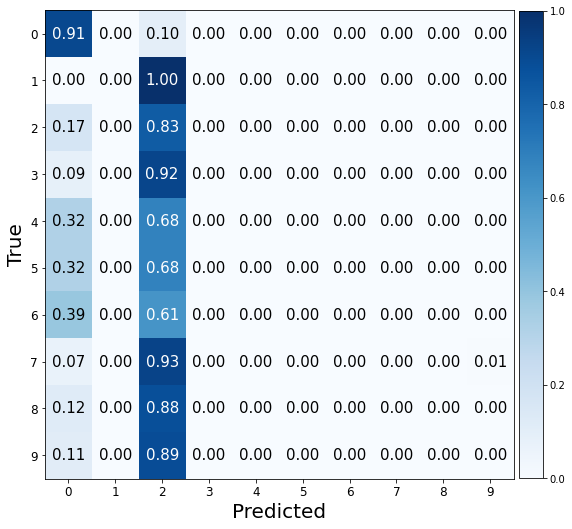

###################

ne: 100, wd:0.001, lr: 0.001, bs:512 
Valid Evaluation loss: 0.6974508166313171. f1:0.8562221272726948 acc: 0.8565000295639038 


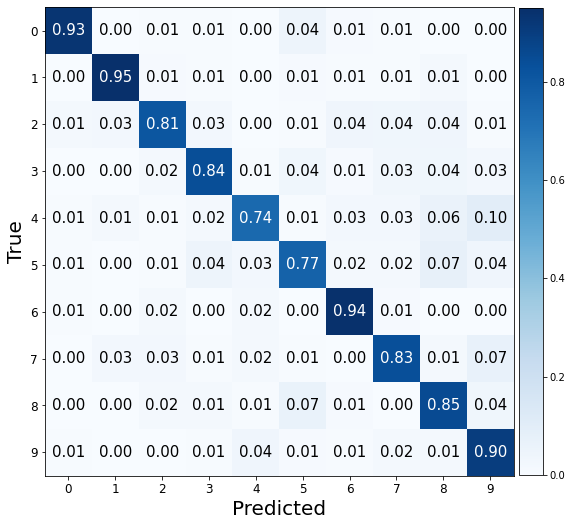

###################

ne: 100, wd:0.01, lr: 0.001, bs:512 
Valid Evaluation loss: 0.7221992015838623. f1:0.8650871929901827 acc: 0.8654999732971191 


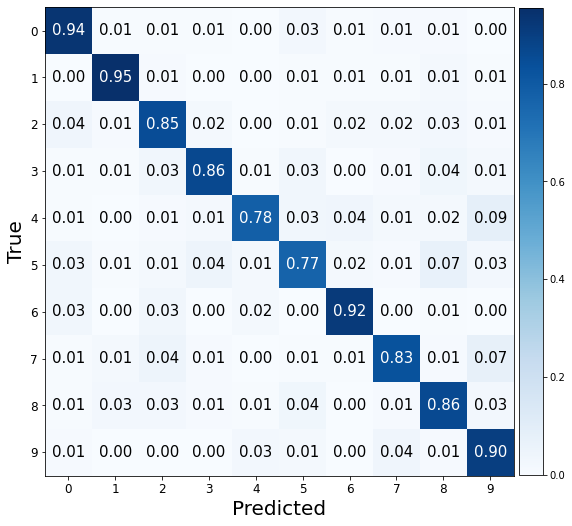

###################

ne: 100, wd:0.1, lr: 0.001, bs:512 
Valid Evaluation loss: 0.6084602475166321. f1:0.8732555496088187 acc: 0.8730000257492065 


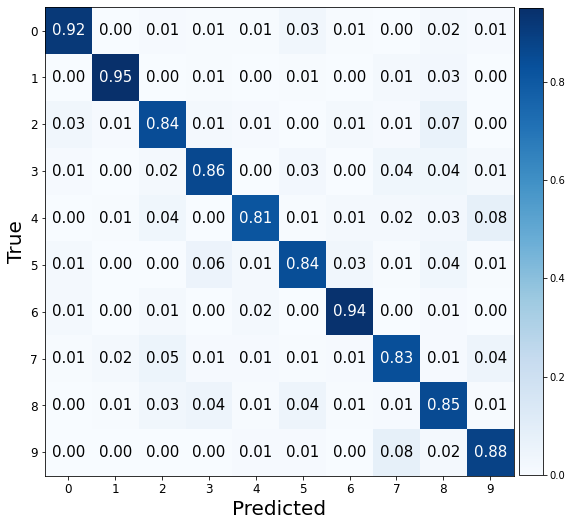

###################

ne: 100, wd:0.001, lr: 0.01, bs:512 
Valid Evaluation loss: 1.9141849279403687. f1:0.2949748044415985 acc: 0.33399999141693115 


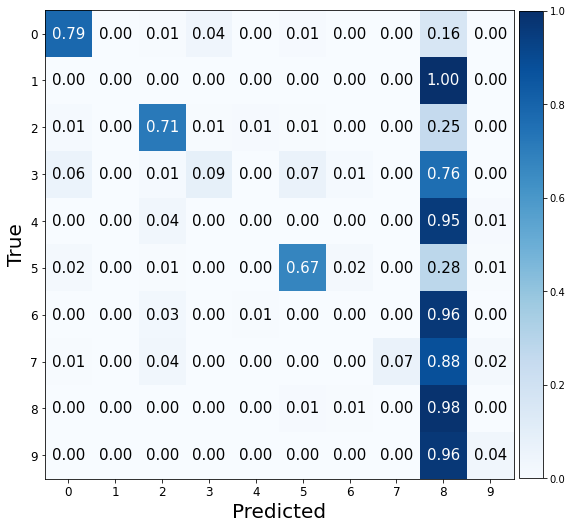

###################

ne: 100, wd:0.01, lr: 0.01, bs:512 
Valid Evaluation loss: 1.5878803730010986. f1:0.4789880136850416 acc: 0.4964999854564667 


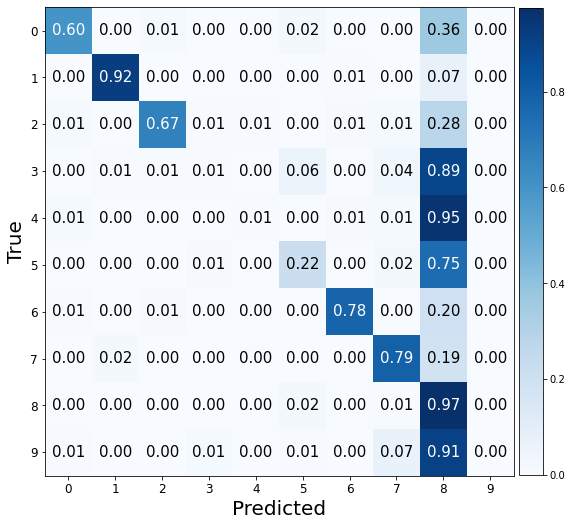

###################

ne: 100, wd:0.1, lr: 0.01, bs:512 
Valid Evaluation loss: 0.9847381711006165. f1:0.7393459399146092 acc: 0.7404999732971191 


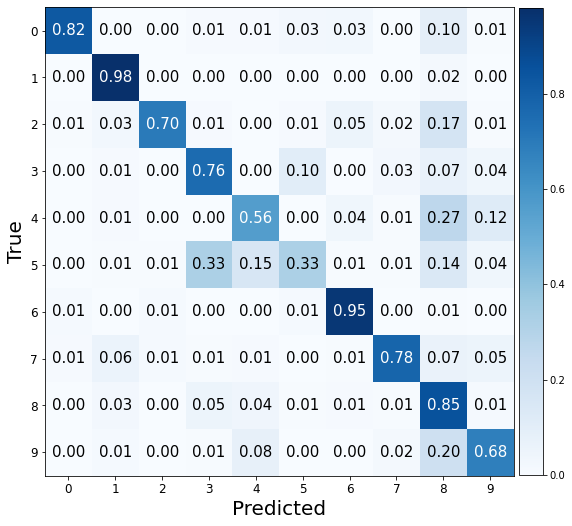

###################

ne: 100, wd:0.001, lr: 0.1, bs:512 
Valid Evaluation loss: 2.3025882244110107. f1:0.01818181818181818 acc: 0.10000000149011612 


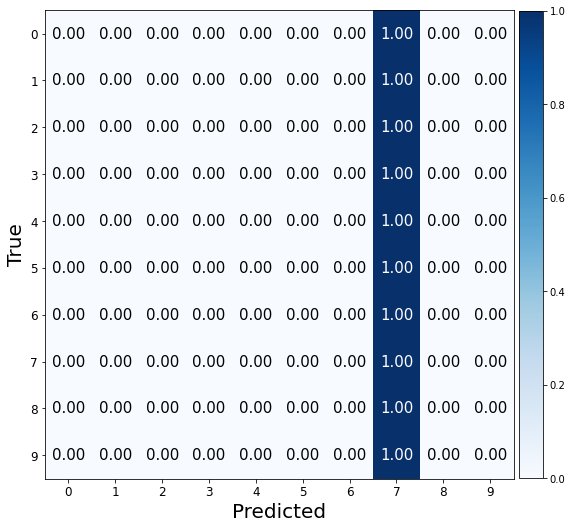

###################

ne: 100, wd:0.01, lr: 0.1, bs:512 
Valid Evaluation loss: 2.3025903701782227. f1:0.01818181818181818 acc: 0.10000000149011612 


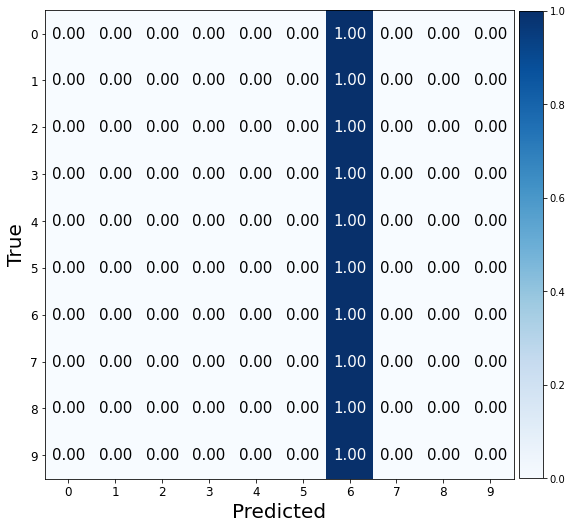

###################

ne: 100, wd:0.1, lr: 0.1, bs:512 
Valid Evaluation loss: 2.3083302974700928. f1:0.01818181818181818 acc: 0.10000000149011612 


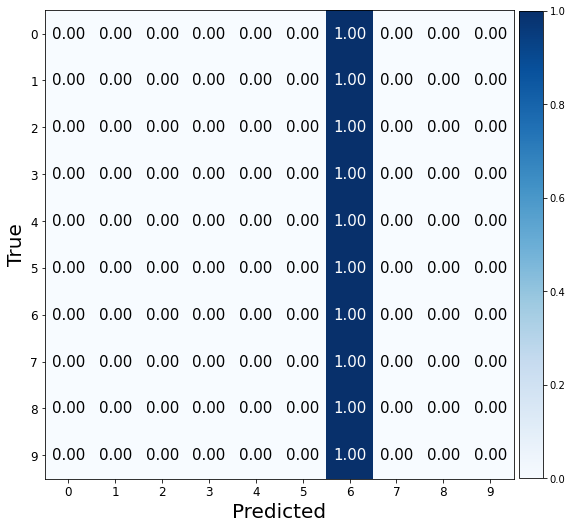

###################

ne: 100, wd:0.001, lr: 0.001, bs:1024 
Valid Evaluation loss: 0.7015230059623718. f1:0.8455597319841445 acc: 0.8454999923706055 


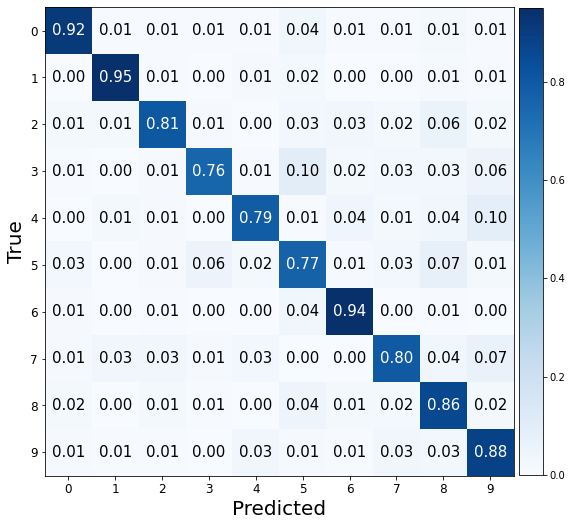

###################

ne: 100, wd:0.01, lr: 0.001, bs:1024 
Valid Evaluation loss: 0.6020562052726746. f1:0.8684854118401357 acc: 0.8684999942779541 


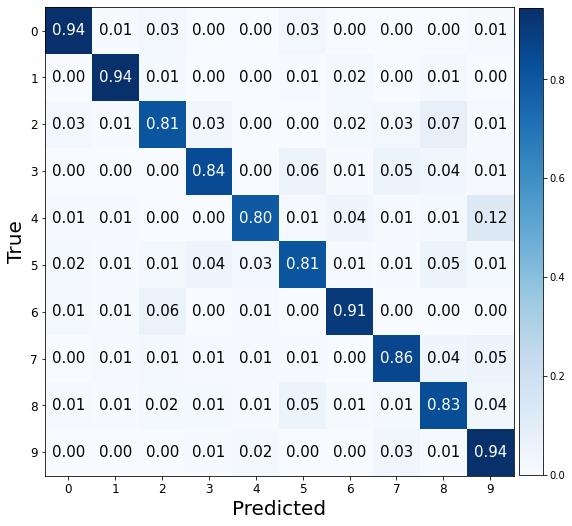

###################

ne: 100, wd:0.1, lr: 0.001, bs:1024 
Valid Evaluation loss: 0.662000298500061. f1:0.8487500673469338 acc: 0.8489999771118164 


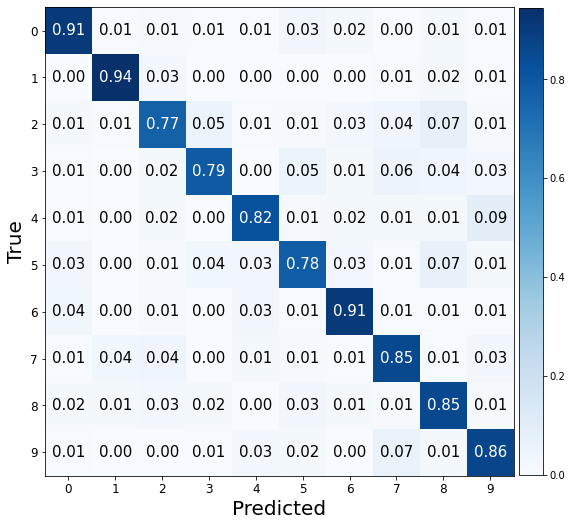

###################

ne: 100, wd:0.001, lr: 0.01, bs:1024 
Valid Evaluation loss: 1.7417445182800293. f1:0.4222288795469824 acc: 0.445499986410141 


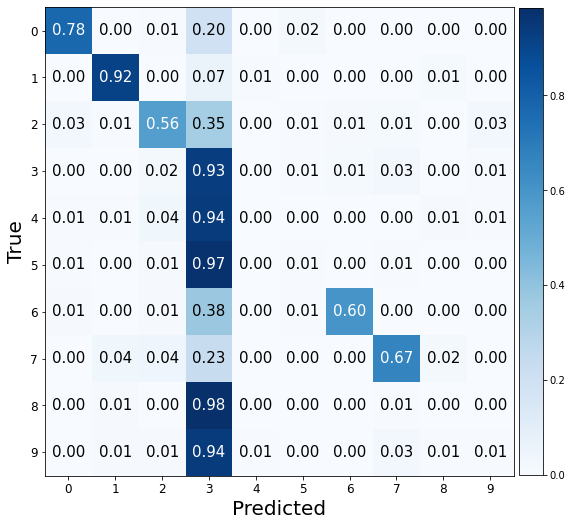

###################

ne: 100, wd:0.01, lr: 0.01, bs:1024 
Valid Evaluation loss: 1.467782735824585. f1:0.49627002767924805 acc: 0.5220000147819519 


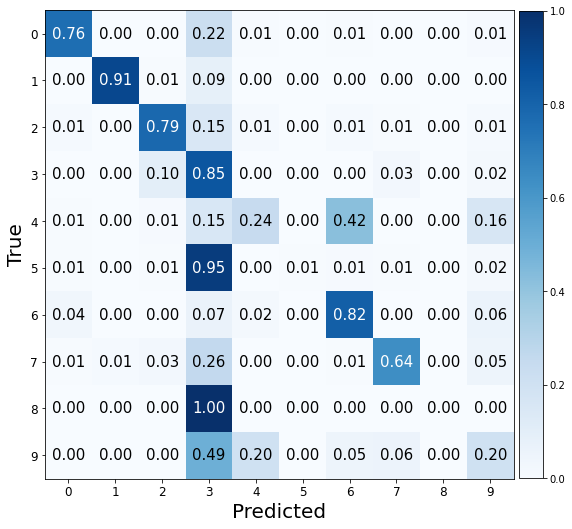

###################

ne: 100, wd:0.1, lr: 0.01, bs:1024 
Valid Evaluation loss: 1.8167119026184082. f1:0.22531765381372315 acc: 0.2994999885559082 


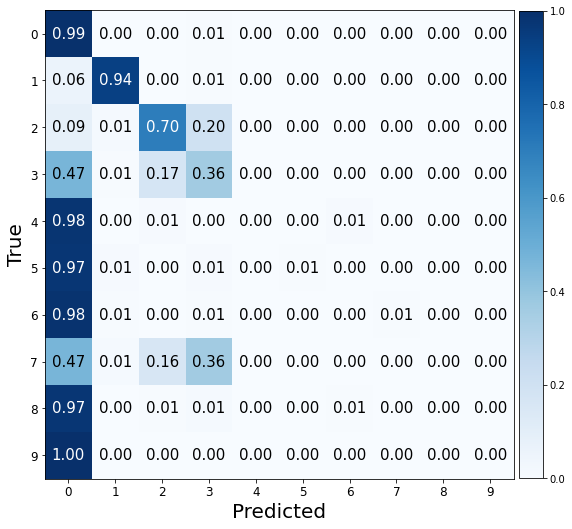

###################

ne: 100, wd:0.001, lr: 0.1, bs:1024 
Valid Evaluation loss: 2.2933108806610107. f1:0.025940482874789443 acc: 0.10400000214576721 


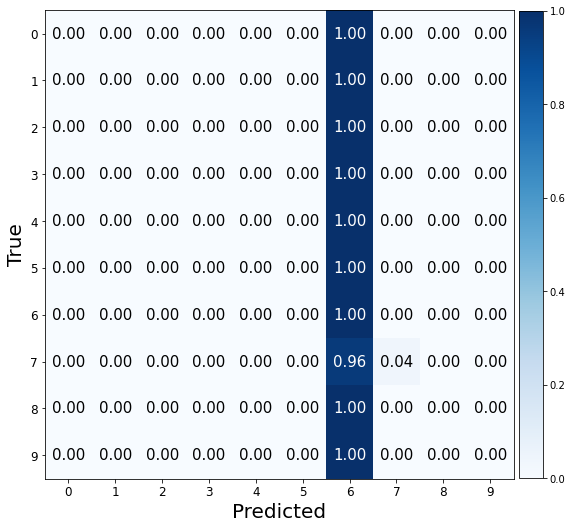

###################

ne: 100, wd:0.01, lr: 0.1, bs:1024 
Valid Evaluation loss: 2.4935996532440186. f1:0.0777742369167953 acc: 0.14149999618530273 


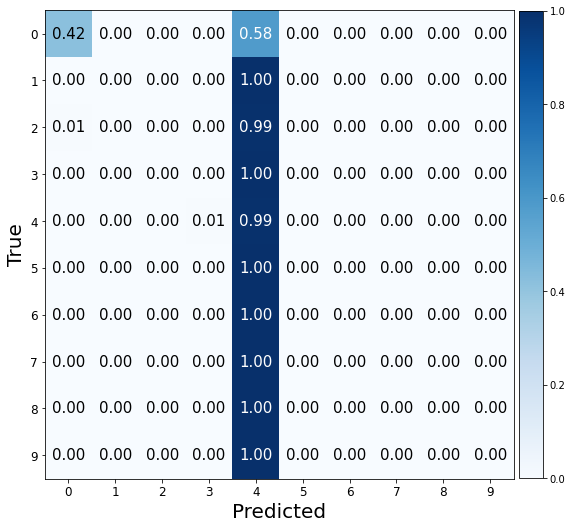

###################

ne: 100, wd:0.1, lr: 0.1, bs:1024 
Valid Evaluation loss: 2.2849414348602295. f1:0.06637723392759716 acc: 0.13050000369548798 


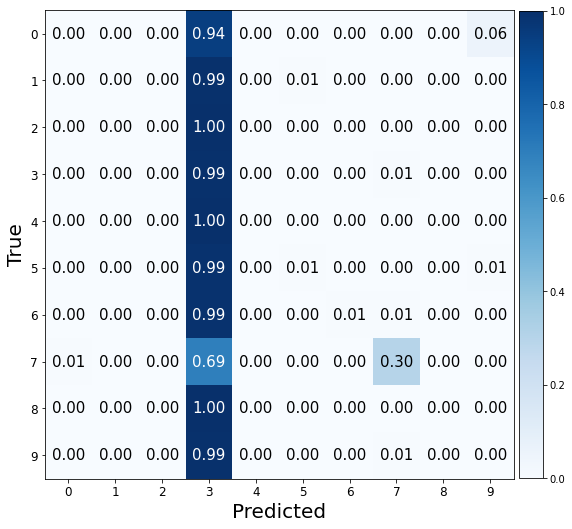

###################

ne: 150, wd:0.001, lr: 0.001, bs:256 
Valid Evaluation loss: 0.6316325664520264. f1:0.8512512081917262 acc: 0.8514999747276306 


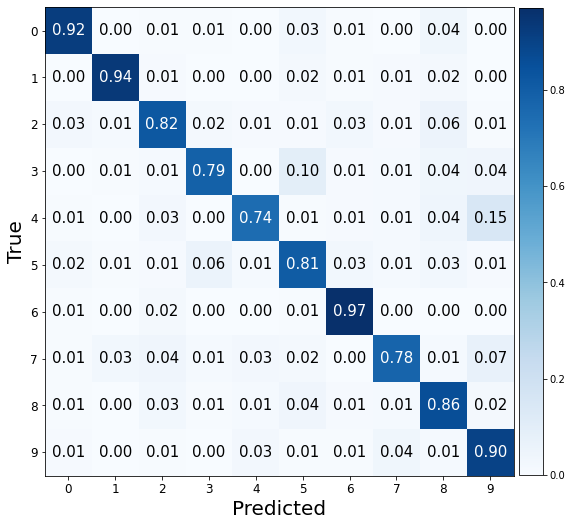

###################

ne: 150, wd:0.01, lr: 0.001, bs:256 
Valid Evaluation loss: 0.6692714691162109. f1:0.8553026107199724 acc: 0.8550000190734863 


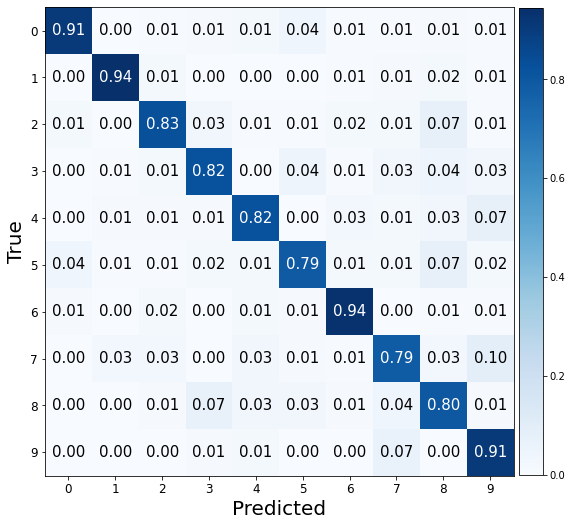

###################

ne: 150, wd:0.1, lr: 0.001, bs:256 
Valid Evaluation loss: 0.5606502890586853. f1:0.8626785258170864 acc: 0.8629999756813049 


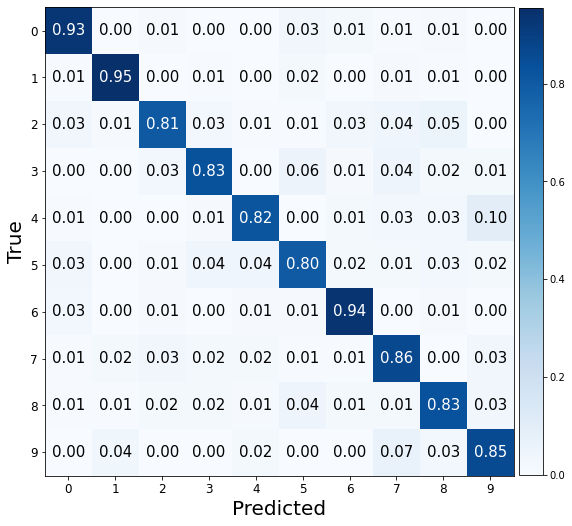

###################

ne: 150, wd:0.001, lr: 0.01, bs:256 
Valid Evaluation loss: 0.9520845413208008. f1:0.7236549191852784 acc: 0.7475000023841858 


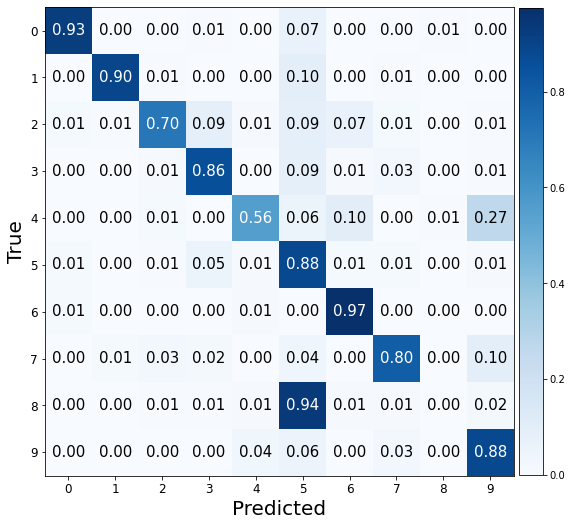

###################

ne: 150, wd:0.01, lr: 0.01, bs:256 
Valid Evaluation loss: 1.3594781160354614. f1:0.6260264628830179 acc: 0.6315000057220459 


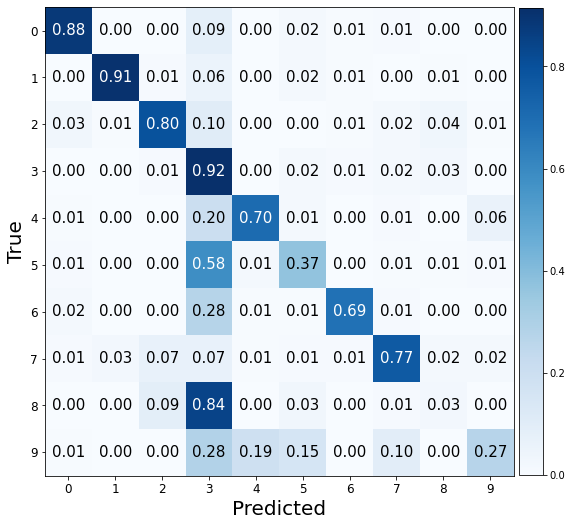

###################

ne: 150, wd:0.1, lr: 0.01, bs:256 
Valid Evaluation loss: 0.9622685313224792. f1:0.6950696145105228 acc: 0.7085000276565552 


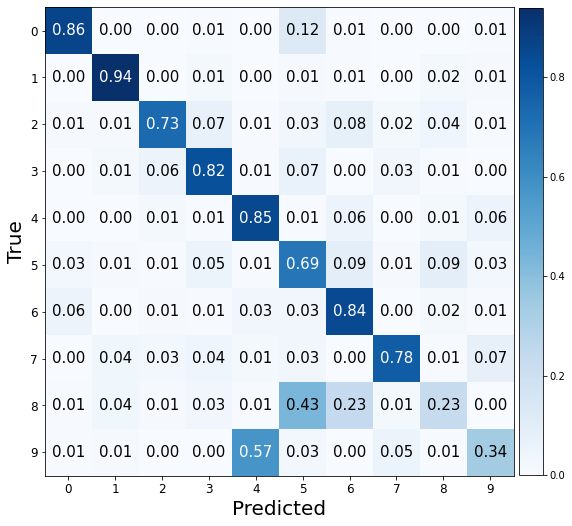

###################

ne: 150, wd:0.001, lr: 0.1, bs:256 
Valid Evaluation loss: 2.302586317062378. f1:0.01818181818181818 acc: 0.10000000149011612 


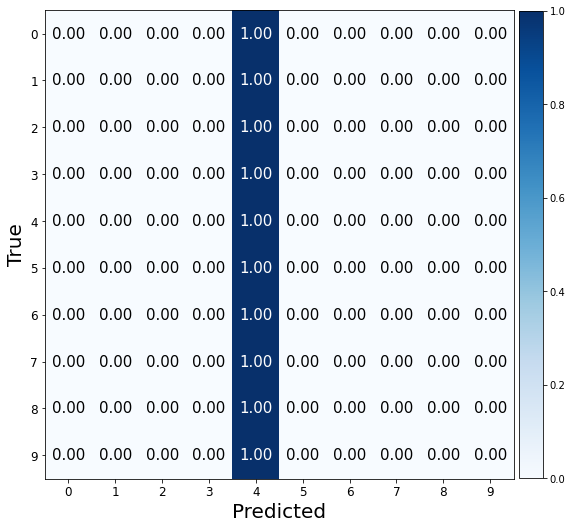

###################

ne: 150, wd:0.01, lr: 0.1, bs:256 
Valid Evaluation loss: 2.3025879859924316. f1:0.01818181818181818 acc: 0.10000000149011612 


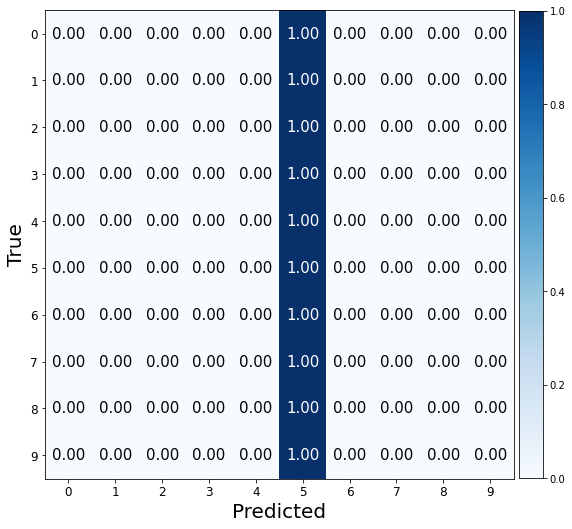

###################

ne: 150, wd:0.1, lr: 0.1, bs:256 
Valid Evaluation loss: 2.2897109985351562. f1:0.07095154182205562 acc: 0.13349999487400055 


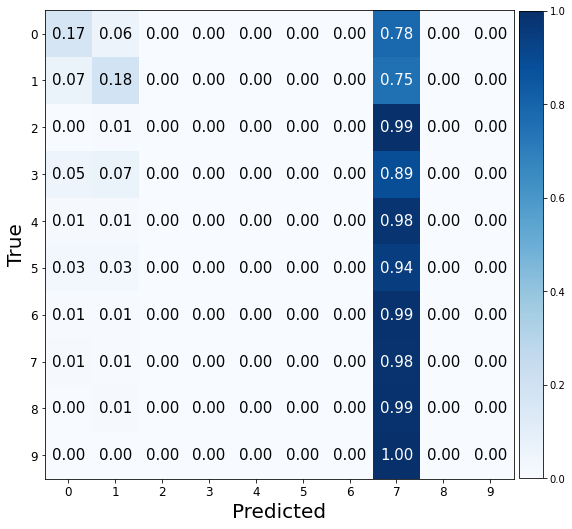

###################

ne: 150, wd:0.001, lr: 0.001, bs:512 
Valid Evaluation loss: 0.8475240468978882. f1:0.8688986190950192 acc: 0.8690000176429749 


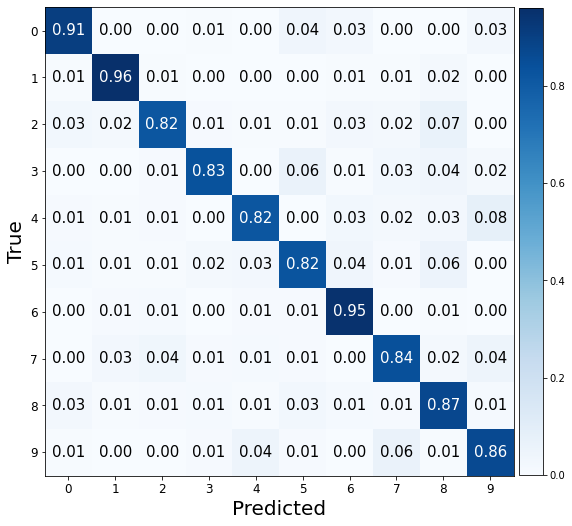

###################

ne: 150, wd:0.01, lr: 0.001, bs:512 
Valid Evaluation loss: 0.6441317796707153. f1:0.8188664945283147 acc: 0.8195000290870667 


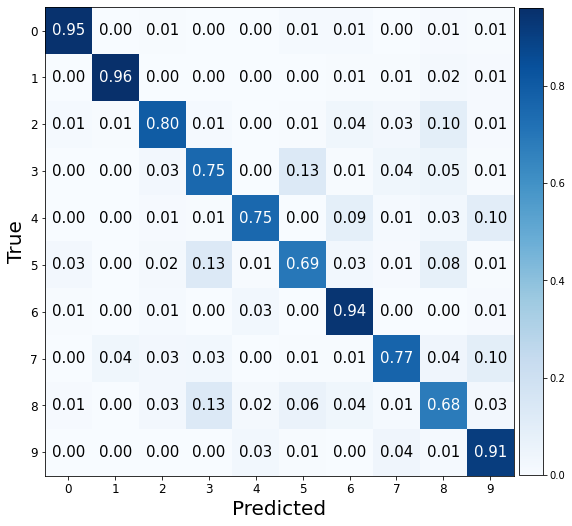

###################

ne: 150, wd:0.1, lr: 0.001, bs:512 
Valid Evaluation loss: 0.5141887068748474. f1:0.870112533574197 acc: 0.8700000047683716 


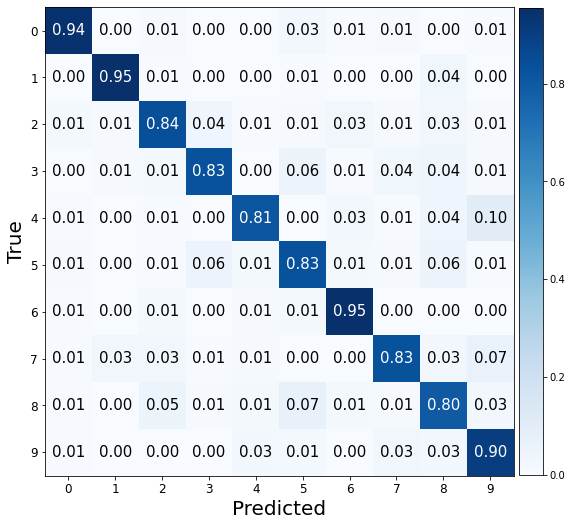

###################

ne: 150, wd:0.001, lr: 0.01, bs:512 
Valid Evaluation loss: 1.4922693967819214. f1:0.4755664804782257 acc: 0.5055000185966492 


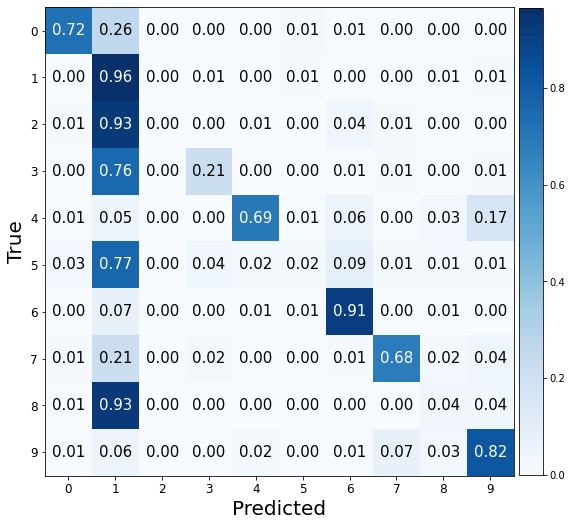

###################

ne: 150, wd:0.01, lr: 0.01, bs:512 
Valid Evaluation loss: 1.370592474937439. f1:0.507055941657601 acc: 0.5289999842643738 


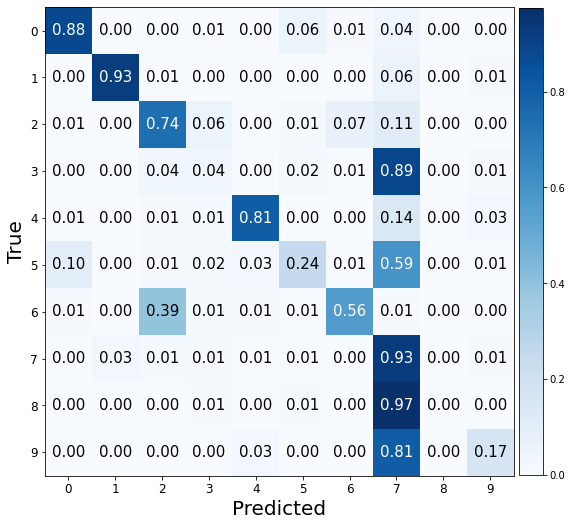

###################

ne: 150, wd:0.1, lr: 0.01, bs:512 
Valid Evaluation loss: 1.6238609552383423. f1:0.3558409009978934 acc: 0.4074999988079071 


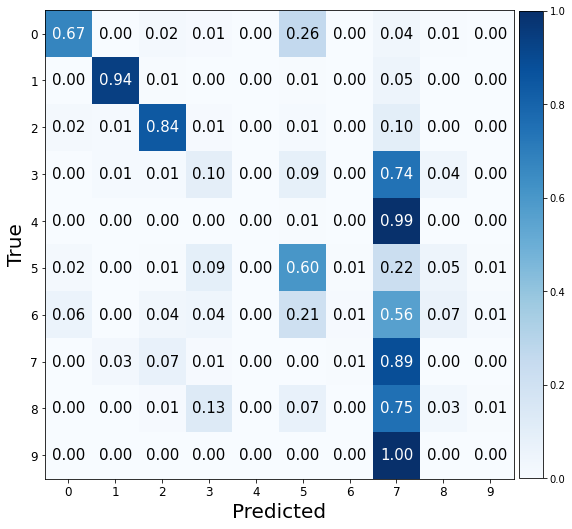

###################

ne: 150, wd:0.001, lr: 0.1, bs:512 
Valid Evaluation loss: 2.3025853633880615. f1:0.01818181818181818 acc: 0.10000000149011612 


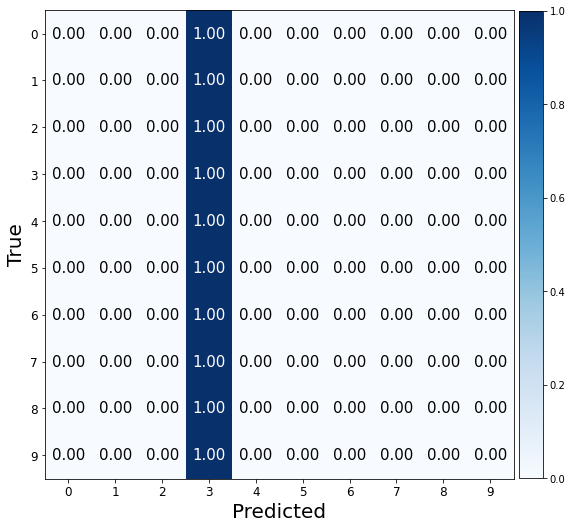

###################

ne: 150, wd:0.01, lr: 0.1, bs:512 
Valid Evaluation loss: 3.389747142791748. f1:0.13397750790758872 acc: 0.17800000309944153 


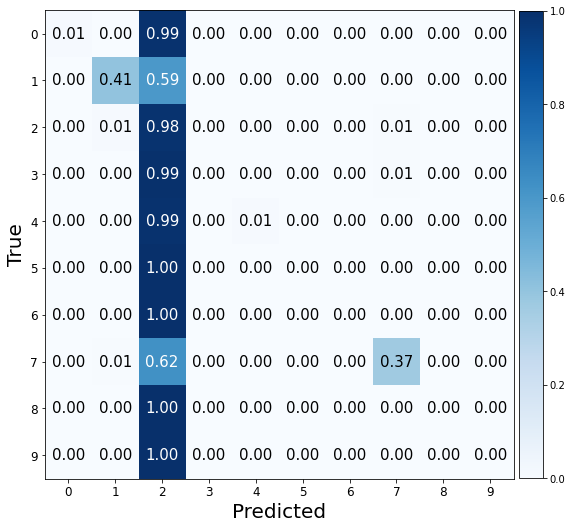

###################

ne: 150, wd:0.1, lr: 0.1, bs:512 
Valid Evaluation loss: 2.2005934715270996. f1:0.10467826567246616 acc: 0.17550000548362732 


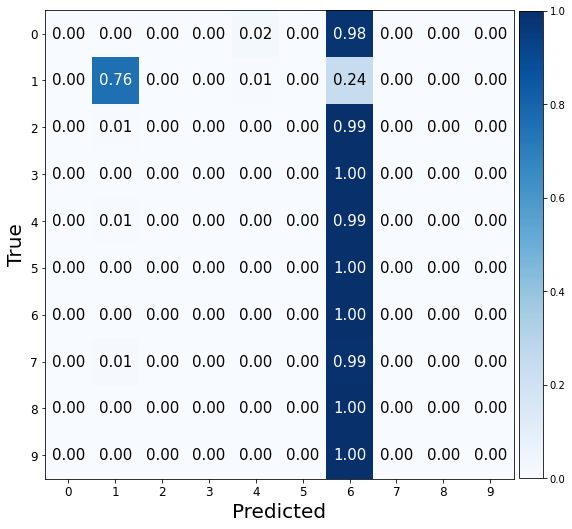

###################

ne: 150, wd:0.001, lr: 0.001, bs:1024 
Valid Evaluation loss: 0.7278896570205688. f1:0.8397640158066164 acc: 0.8399999737739563 


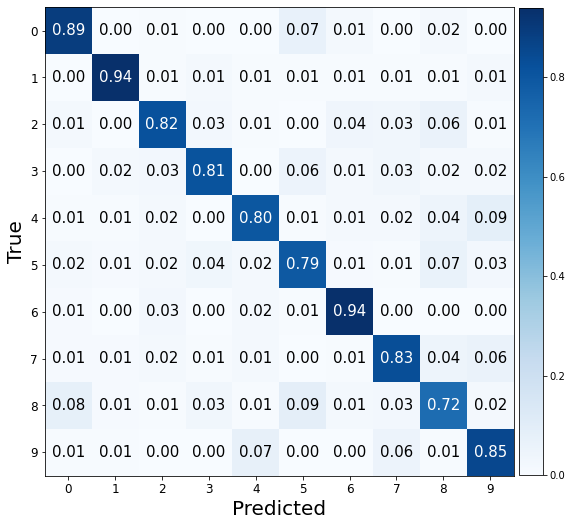

###################

ne: 150, wd:0.01, lr: 0.001, bs:1024 
Valid Evaluation loss: 0.7113513350486755. f1:0.8498220852766032 acc: 0.8500000238418579 


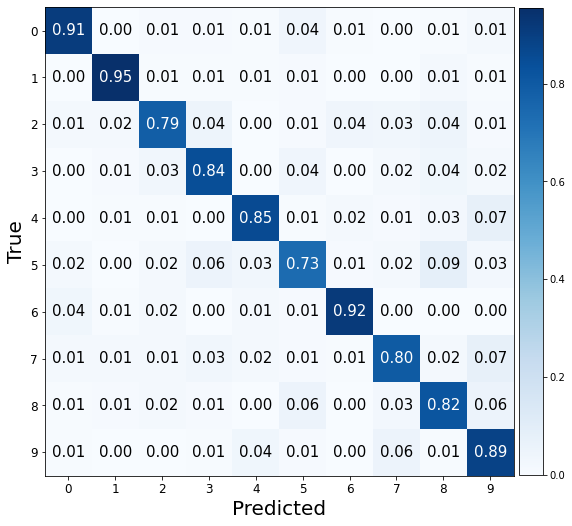

###################

ne: 150, wd:0.1, lr: 0.001, bs:1024 
Valid Evaluation loss: 0.5397151708602905. f1:0.8719143196875931 acc: 0.871999979019165 


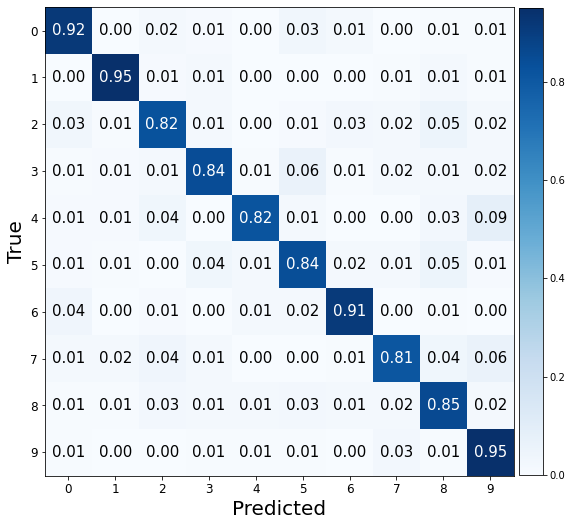

###################

ne: 150, wd:0.001, lr: 0.01, bs:1024 
Valid Evaluation loss: 1.0069679021835327. f1:0.7849344722966013 acc: 0.7770000100135803 


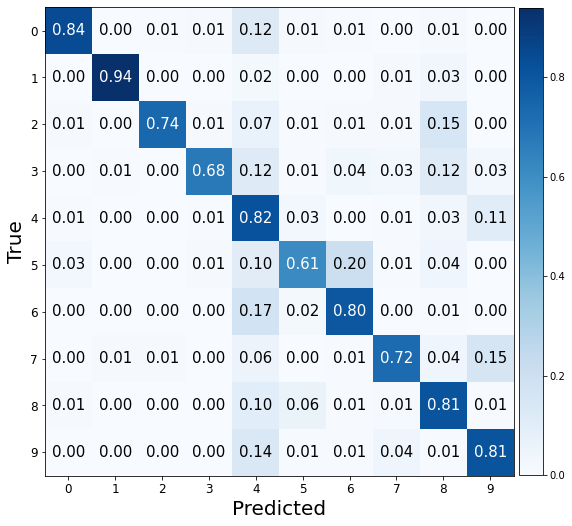

###################

ne: 150, wd:0.01, lr: 0.01, bs:1024 
Valid Evaluation loss: 1.1667368412017822. f1:0.6995069139242533 acc: 0.7074999809265137 


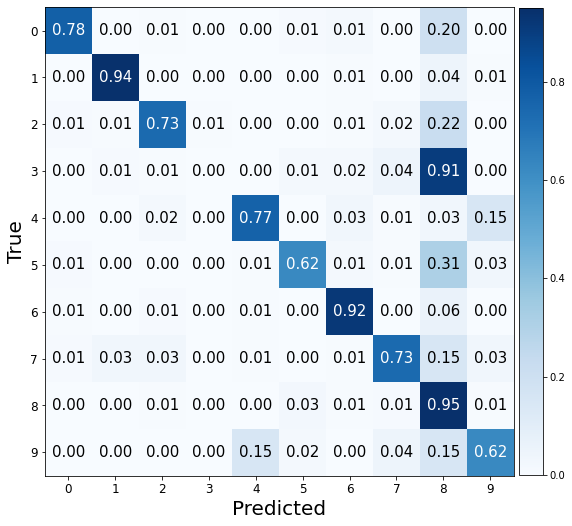

###################

ne: 150, wd:0.1, lr: 0.01, bs:1024 
Valid Evaluation loss: 1.111817479133606. f1:0.6169370048600735 acc: 0.6520000100135803 


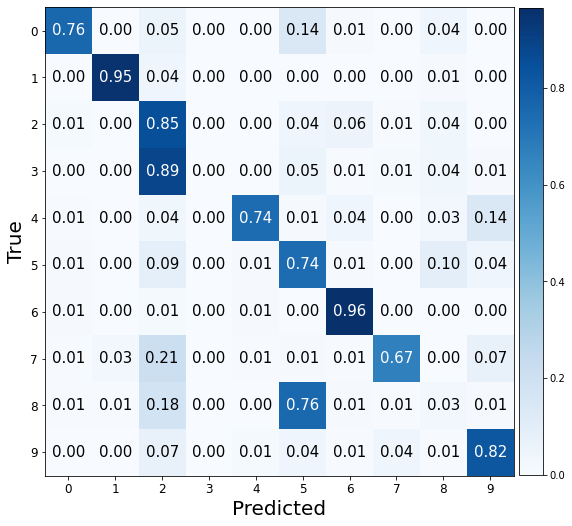

###################

ne: 150, wd:0.001, lr: 0.1, bs:1024 
Valid Evaluation loss: 2.302595853805542. f1:0.01818181818181818 acc: 0.10000000149011612 


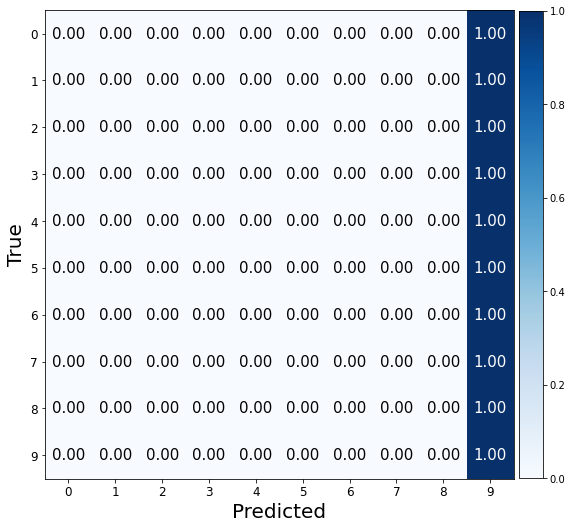

###################

ne: 150, wd:0.01, lr: 0.1, bs:1024 
Valid Evaluation loss: 2.7094645500183105. f1:0.16458593617058376 acc: 0.21850000321865082 


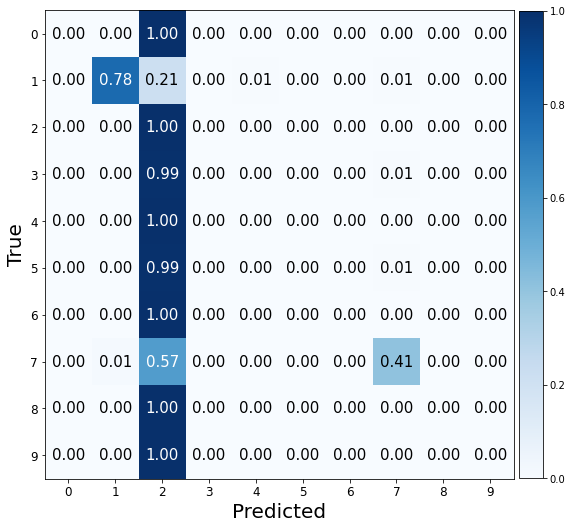

###################

ne: 150, wd:0.1, lr: 0.1, bs:1024 
Valid Evaluation loss: 2.2044312953948975. f1:0.1124700016550811 acc: 0.18850000202655792 


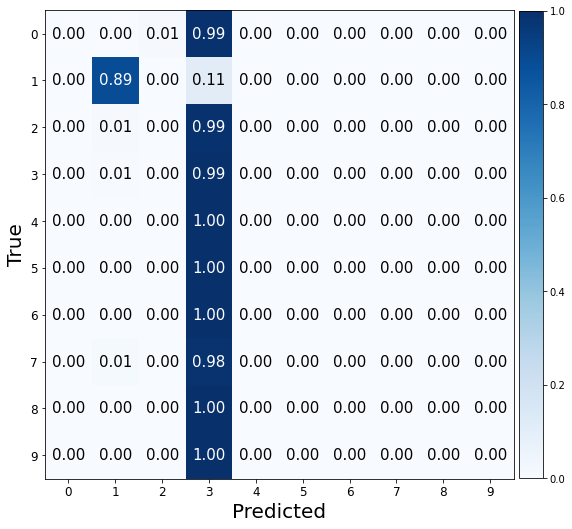

###################



In [40]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

ne_list = [50,100,150]
lr_list = [0.001,0.01,0.1]
wd_list = [0.001,0.01,0.1]
bs_list = [256,512,1024]

dict_f1 = {}      #Definimos un dict_f1 para guardar el f1 de cada modelo y luego encontrar rápidamente el que tiene un mejor aprendizaje

pbar = tqdm(total=len(bs_list)*len(lr_list)*len(wd_list)*len(ne_list))

for ne in ne_list:
  for bs in bs_list:
    train_ds = TensorDataset(X_train, Y_train)
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

    for lr in lr_list:
      for wd in wd_list:
        input_dim = 28*28
        out_dim = 10
        hidden = 50

        model = torch.nn.Sequential(
          torch.nn.Linear(input_dim, hidden),
          torch.nn.ReLU(),
          torch.nn.Linear(hidden, out_dim)
        )

        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        criterion = torch.nn.CrossEntropyLoss()

        print('ne: {}, wd:{}, lr: {}, bs:{} '.format(ne,wd,lr,bs))
        f1, matrix = train_valid(model,ne,optimizer,criterion)
        print('###################\n')
        pbar.update()

      dict_f1[f1] = [ne, lr, wd, bs, matrix]
pbar.close()

f1_max:0.8733, n_epoch:100, lr:0.001, weight_decay:0.1, batch_size:512 


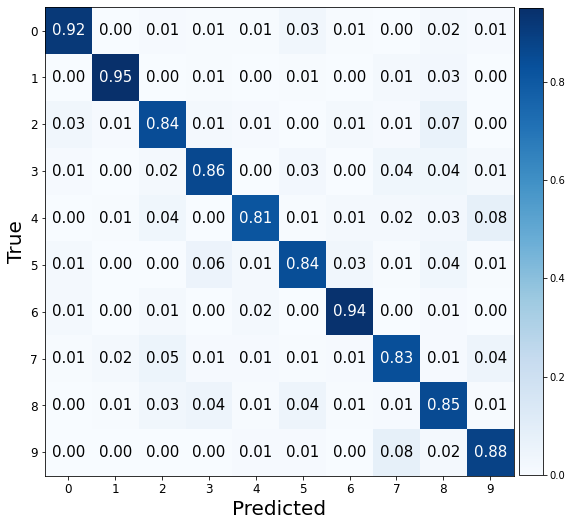

In [41]:
#Llamamos al máximo de f1_dict

f1_max = max(dict_f1.keys())
print("f1_max:{:.4f}, n_epoch:{}, lr:{}, weight_decay:{}, batch_size:{} ".format(f1_max,*dict_f1[f1_max][:4]))

dict_f1[f1_max][-1]

### Tenemos entonces los siguientes datos
- Modelo 1: 100 neuronas ocultas y 5 capas  
f1_max:0.9229, n_epoch:150, lr:0.001, weight_decay:0.1, batch_size:512    
- Modelo 2: 50 neuronas ocultas y 3 capas  
f1_max:0.8733, n_epoch:100, lr:0.001, weight_decay:0.1, batch_size:512  


#### Cuyas matrices de confusión se ven en el código anterior. De estos dos modelos podemos concluir que, pese a utilizar mayor número de épocas, el primero, con más neuronas y más capas, consigue un mejor f1 con una diferencia significativa del 5%. Esto nos lleva a concluir que, si tenemos el espacio y el poder suficiente, podemos conseguir mejores resultados. Adicional a esto, el parámetro weight_decay nos ayuda a no caer en el sobreajuste.
